# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `03_eda.ipynb`                                          |
| Purpose  | Conduct EDA of pre-processed data.                      |

> (TODO - write more explaining notebook)

# 1 - Setup

In [1]:
# imports from Python standard library
import re

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import matplotlib.pyplot as plt             # pip install matplotlib
import nltk                                 # pip install nltk
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas
import seaborn as sns                       # pip install seaborn
import squarify                             # pip install squarify

from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# imports from tweet_turing.py
import tweet_turing as tur      # note - different import approach from prior notebooks

# imports from tweet_turing_paths.py
from tweet_turing_paths import local_data_paths, local_snapshot_paths, gcp_data_paths, \
    gcp_snapshot_paths, gcp_project_name, gcp_bucket_name, gcp_key_file

In [4]:
# pandas options
pd.set_option('display.max_colwidth', None)

# seaborn options
sns.set_theme(context='paper', style='ticks', palette='bright', font='Arial', rc={'figure.dpi': 200})
twitter_colors = {
    'blue': r"#1DA1F2",     # source: https://usbrandcolors.com/twitter-colors/
    'black': r"#14171A",
    'dark gray': r"#657786",
    'dark blue': r"#0f5580" # "blue" with brightness changed 88% to 50%, non-standard color
    }

# nltk setup
_ = nltk.download('stopwords', quiet=True)
_ = nltk.download('punkt', quiet=True)
stop_words = set(stopwords.words('english'))

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [5]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [5]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

# 2 - Load dataset

In [6]:
# note this cell requires package `pyarrow` to be installed in environment
parq_filename: str = "merged_df_preprocessed.parquet.snappy"
parq_path: str = f"{snapshot_paths['parq_snapshot']}{parq_filename}"

if (local_or_cloud == "local"):
    merged_df = pd.read_parquet(parq_path, engine='pyarrow')
elif (local_or_cloud == "cloud"):
    pass

# 3 - EDA Basics

Display basic pandas info, showing number of entries, columns (and their dtypes) within dataframe, and memory usage.

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624894 entries, 0 to 3624893
Data columns (total 18 columns):
 #   Column              Dtype              
---  ------              -----              
 0   external_author_id  string             
 1   author              string             
 2   content             string             
 3   region              string             
 4   language            string             
 5   following           uint64             
 6   followers           uint64             
 7   updates             uint64             
 8   post_type           string             
 9   is_retweet          float64            
 10  account_category    string             
 11  tweet_id            string             
 12  tco1_step1          string             
 13  data_source         string             
 14  has_url             int64              
 15  emoji_text          object             
 16  emoji_count         int64              
 17  publish_date        datetim

See a few sample rows:

In [8]:
merged_df.sample(2)

,external_author_id,author,content,region,language,following,followers,updates,post_type,is_retweet,account_category,tweet_id,tco1_step1,data_source,has_url,emoji_text,emoji_count,publish_date
1808069,890000000000000000,LAWWAANCTR,#laww New Poll Reveals How Many Americans Support Transgender Military Members https://t.co/Rr5wP3vbgU #law https://t.co/EeZCJS7AXz,Unknown,English,990,72,158,<NA>,0.0,RightTroll,890640339043614720,https://twitter.com/lawwaanCtr/status/890640339043614720/photo/1,Troll,1,[],0,2017-07-27 18:29:00+00:00
2666072,152224898,anibundel,RT @CatConWorldwide: Louis Wain's cats know how to party. https://t.co/UumXRuFhWS,wildsofFairfax,en,1005,3025,6,retweeted,1.0,Verified_User,937159949335040000,https://twitter.com/CatConWorldwide/status/937159713136959488/photo/1,verified_random,1,[],0,2017-12-03 03:21:58+00:00


Examine nulls / missing values.

In [9]:
merged_df.isnull().sum()

external_author_id          0
author                      0
content                     0
region                 180192
language                    0
following                   0
followers                   0
updates                     0
post_type             2084245
is_retweet                  0
account_category            0
tweet_id                    0
tco1_step1            1427061
data_source                 0
has_url                     0
emoji_text                  0
emoji_count                 0
publish_date                0
dtype: int64

## 3.1 Additional Pre-processing

As needed, a few additional pre-processing steps are added to this section to aid with subsequent EDA sections.

### 3.1.1 Troll / Verified Label

Our `data_source` feature is close to being a differentiator of our target classes of Troll / Authentic. Feature `data_source` contains values below:

In [7]:
merged_df['data_source'].value_counts(dropna=False)

Troll              2116866
verified_random    1070661
verified_user       437367
Name: data_source, dtype: Int64

We will combine the tweets with `data_source` values *verified_random* and *verified_user* into a single *Verified* label, and store the result in a new column.

In [8]:
data_source_mapping = {
    'Troll': 'Troll', 
    'verified_user': 'Verified', 
    'verified_random': 'Verified'
    }

merged_df['class'] = merged_df['data_source'].map(data_source_mapping)

merged_df['class'].value_counts(dropna=False)

Troll       2116866
Verified    1508028
Name: class, dtype: int64

# 4 - Features (Individual Analysis)

The table below provides a description of the features we have in our dataset to this point.

| **Feature** | **Description** | **Data Type** | **Notes** |
| :---: | --- | :---: | --- |
| `external_author_id` | Author ID | Nominal | Unique identifier / primary key for twitter accounts |
| `author` | Author Twitter Handle | Categorical | The Twitter handle (i.e. username) of this tweet's author |
| `content` | Tweet Content | String Object | The text of the tweet itself, including hashtags, hyperlinks, mentions, etc. |
| `region` | Region | Categorical | A region classification. For troll tweets, determined by [Social Studio (link: help.salesforce.com)](https://help.salesforce.com/articleView?id=000199367&type=1) |
| `language` | Language | Categorical | The language of the tweet |
| `following` | Number of Other Accounts Followed | Continuous Numerical | The number of other accounts that this tweet's account is following. |
| `followers` | Number of Other Accounts Following | Continuous Numerical | The number of other accounts that follow this tweet's account. |
| `updates` | Number of Update Actions | Continuous Numerical | A composite measurement of public metrics for interaction by other users with a tweet. |
| `is_retweet` | Retweet | Binary | Binary indicator of whether or not the tweet is a retweet. |
| `account_category` | Account Category | Nominal | A categorization, primarily for differentiating types of troll accounts. |
| `tweet_id` | Tweet ID | Nominal | Unique identifier for each tweet, assigned by Twitter. |
| `tco1_step1` | First URL from within Tweet Content | Nominal | The first URL redirected to after http://t.co/... |
| `data_source` | Data Source | Categorical | Either "Troll", "verified_user", or "verified_random" |
| `has_url` | Tweet Has URL | Binary | Does this tweet contain a URL? |
| `emoji_text` | Emoji Text | String / List of Strings | A list of natural language descriptions of each unique emoji used. |
| `emoji_count` | Number of Emoji | Continuous Numerical | The quantity of emoji used within the `content` of this tweet. |
| `publish_date` | Publish Date of Tweet | Interval | The original publish date of this tweet. |

## 4.1 - Author ID (`external_author_id`)

We did not conduct extensive individual analysis of this feature because it is an auto-generated value set by Twitter.  

Some additional thoughts:

 - Because these numbers are randomly generated, the magnitude of the ID could not be used as a proxy for account age.
 - Twitter uses a 64-bit integer for this ID and recommends handling them as strings to avoid loss of precision among various implementations of an int64-like type.
 - One possible analysis (coupled with `author`) would be to determine how many values of `author` correspond to a given `external_author_id`. This would potentially indicate a user who changes their Twitter handle more often than average. This would be a great candidate for a map/reduce aggregation task. To collect this data on a large scale would require a *huge* volume of data, though, so we do not plan to attempt it for our project.

## 4.2 - Author Twitter Handle (`author`)

We can examine which Twitter handles are most represented in the dataset (and peek at their account category).

In [12]:
# map: create tuples of (author, account_category)
author_tuples = merged_df.apply(lambda row: (row['author'], row['account_category']), axis='columns')

# reduce: count tuple occurrences and sort
author_tuple_counts = author_tuples.value_counts(ascending=False)

In [13]:
# display top results
pd.concat(
    [
        pd.DataFrame.from_records(
            author_tuple_counts.index, 
            index=author_tuple_counts.index, 
            columns=['author', 'account_category']
            )
        , 
        pd.DataFrame(
            author_tuple_counts.values,
            index=author_tuple_counts.index,
            columns=['count']
            )
    ], 
    axis=1, 
    ).nlargest(20, columns=['count'])

,author,account_category,count
"(EXQUOTE, Commercial)",EXQUOTE,Commercial,53158
"(AskTSA, Verified_User)",AskTSA,Verified_User,49390
"(SCREAMYMONKEY, NewsFeed)",SCREAMYMONKEY,NewsFeed,43956
"(WORLDNEWSPOLI, RightTroll)",WORLDNEWSPOLI,RightTroll,35082
"(AMELIEBALDWIN, RightTroll)",AMELIEBALDWIN,RightTroll,34308
"(TODAYPITTSBURGH, NewsFeed)",TODAYPITTSBURGH,NewsFeed,33377
"(SPECIALAFFAIR, NewsFeed)",SPECIALAFFAIR,NewsFeed,32416
"(SEATTLE_POST, NewsFeed)",SEATTLE_POST,NewsFeed,30680
"(KANSASDAILYNEWS, NewsFeed)",KANSASDAILYNEWS,NewsFeed,28746
"(ROOMOFRUMOR, NewsFeed)",ROOMOFRUMOR,NewsFeed,28259


How many unique Twitter handles are in our dataset?

In [14]:
print(f"Number of unique Twitter handles:\t{merged_df['author'].nunique():,} unique handles")

Number of unique Twitter handles:	142,270 unique handles


## 4.3 - Tweet Content (`content`)

### 4.3.1 - Tweet Length (characters)

First analyzed by Python's built-in `len()` function. What we see is a large spike at $len=140$, but an odd trail of values over $len=900$.

In [15]:
tweet_lengths: pd.DataFrame = merged_df[['content', 'class']].copy()
tweet_lengths['length'] = tweet_lengths['content'].apply(len)

n_140char = tweet_lengths.loc[tweet_lengths['length'] == 140, 'length'].count()
n_280char = tweet_lengths.loc[tweet_lengths['length'] == 280, 'length'].count()

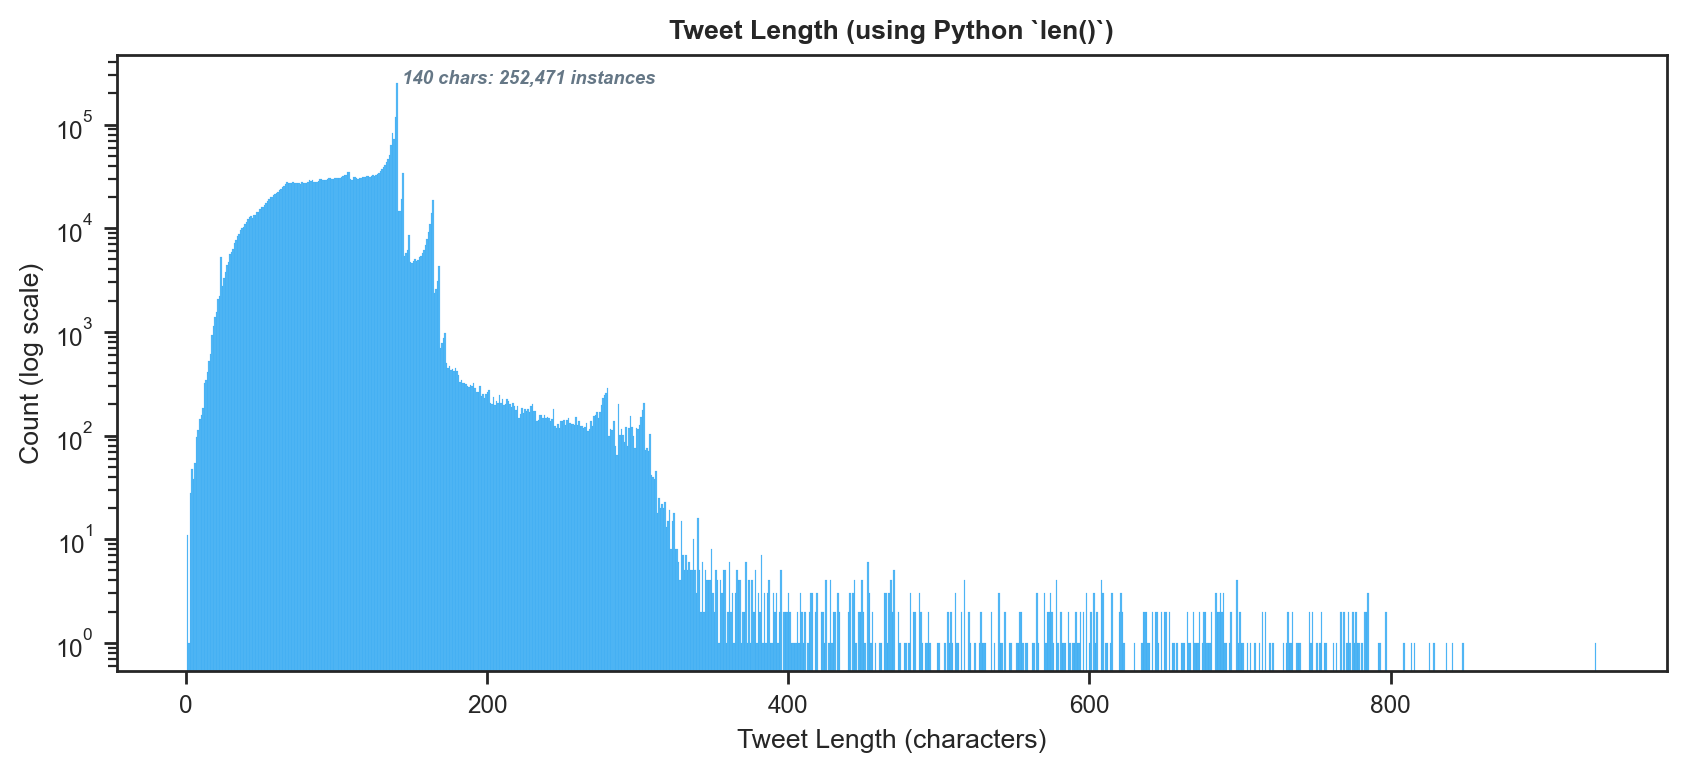

In [16]:
fig, ax = plt.subplots(figsize=(10,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters)")
ax.set_ylabel("Count (log scale)")

sns.histplot(tweet_lengths, 
                x='length', 
                color=twitter_colors['blue'], 
                edgecolor=twitter_colors['blue'],
                discrete=True, 
                ax=ax
            )

plt.text(x=140, y=n_140char, s=f" 140 chars: {n_140char:,} instances", 
            size='x-small', weight='semibold', style='italic', alpha=1.0, color=twitter_colors['dark gray'])

plt.show()

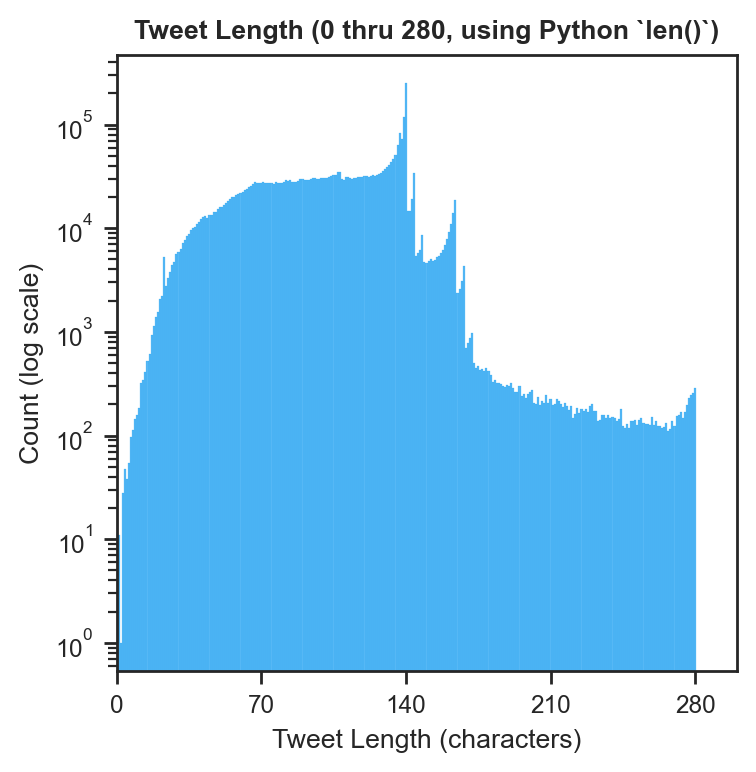

In [22]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters)")
ax.set_ylabel("Count (log scale)")
ax.set_xlim((0,300))
ax.set_xticks([x for x in range(0,300,70)])

sns.histplot(tweet_lengths.loc[tweet_lengths['length'].between(0, 280, inclusive='both')], 
                x='length', 
                color=twitter_colors['blue'],
                edgecolor=twitter_colors['blue'], 
                discrete=True, 
                ax=ax
            )

plt.show()

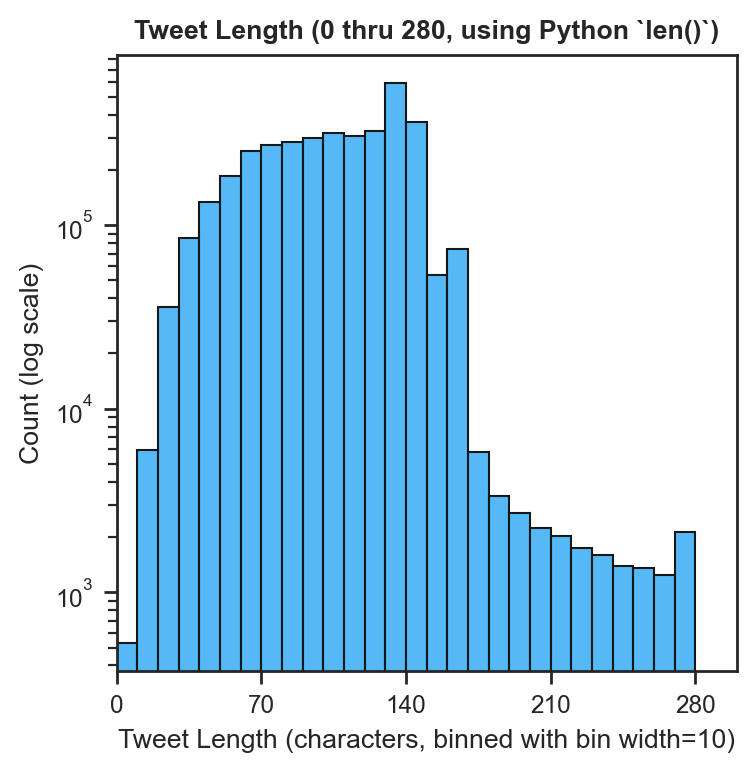

In [25]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_yscale('log')
ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Count (log scale)")
ax.set_xlim((0,300))
ax.set_xticks([x for x in range(0,300,70)])

sns.histplot(tweet_lengths.loc[tweet_lengths['length'].between(0, 280, inclusive='both')], 
                x='length', 
                color=twitter_colors['blue'], 
                bins=28,
                binrange=(0, 280),
                element='bars',
                edgecolor=twitter_colors['black'],
                ax=ax
            )

plt.show()

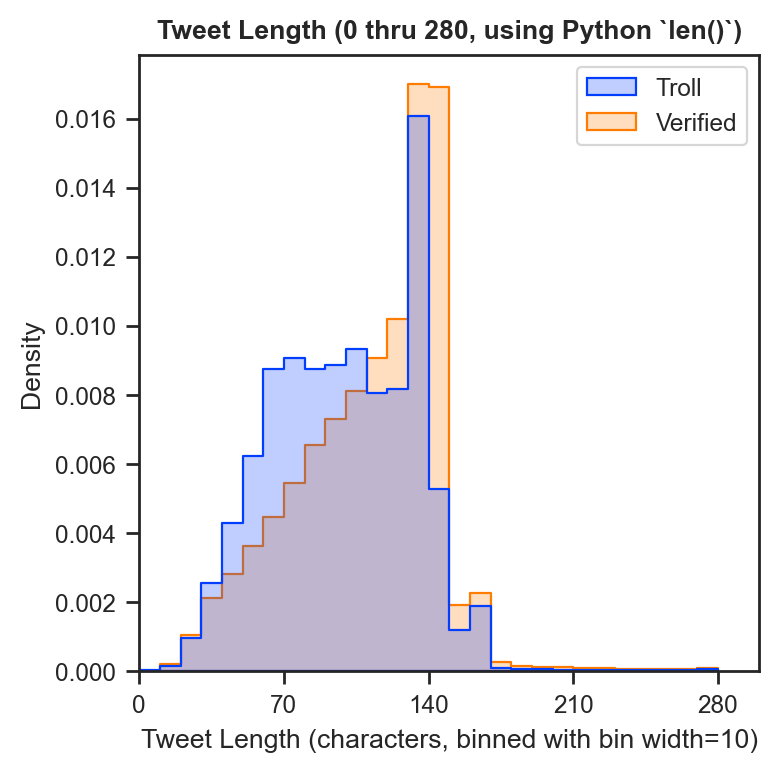

In [26]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Tweet Length (0 thru 280, using Python `len()`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Density")
ax.set_xlim((0,300))
ax.set_xticks([x for x in range(0,300,70)])

sns.histplot(tweet_lengths.loc[tweet_lengths['length'].between(0, 280, inclusive='both')], 
                x='length', 
                hue='class',
                bins=28,
                binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

The manner in which Twitter validates a tweet's length involves a decent amount of complexity, but boils down to that certain elements (emoji, shortened URLs) have a fixed value for number of characters. Twitter provides an open-source library showing how this character counting method but not in Python (available languages are Java, Javascript/Node.js, Ruby, and Objective-C). An external package `tweet-counter` approximates this character counting method in Python (*package source: [[github.com]](https://github.com/nottrobin/tweet-counter)*).

In [27]:
tweet_lengths['length_twitter'] = tweet_lengths.apply(tur.char_count, axis='columns')

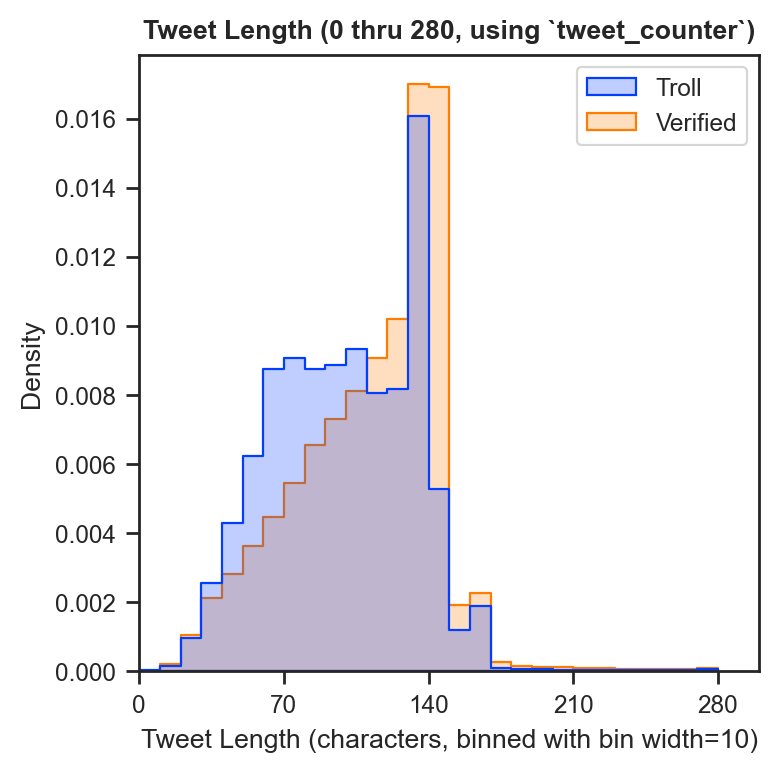

In [29]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Tweet Length (0 thru 280, using `tweet_counter`)", weight='bold')
ax.set_xlabel("Tweet Length (characters, binned with bin width=10)")
ax.set_ylabel("Density")
ax.set_xlim((0,300))
ax.set_xticks([x for x in range(0,300,70)])

sns.histplot(tweet_lengths.loc[tweet_lengths['length_twitter'].between(0, 280, inclusive='both')], 
                x='length', 
                hue='class',
                bins=28,
                binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

Qualitatively it doesn't appear there is a sensible difference between the two counting methods. We can stack the histograms for a better view.

In [30]:
# unpivot the dataframe into long form
tweet_lengths_melted = pd.melt(
    tweet_lengths, 
    id_vars=['class'], 
    value_vars=['length', 'length_twitter'],
    var_name='length_method',
    value_name='length_value',
    ignore_index=False
    ).replace(
        {'length_method': {
                'length': 'Python `len`',
                'length_twitter': '`tweet_counter`'
            }
        }
    )

In [31]:
# check long form results
tweet_lengths_melted.loc[0]

,class,length_method,length_value
0,Troll,Python `len`,156
0,Troll,`tweet_counter`,156


The next few cells we are trying out a few Seaborn plot types to see what kind of visualization they produce.

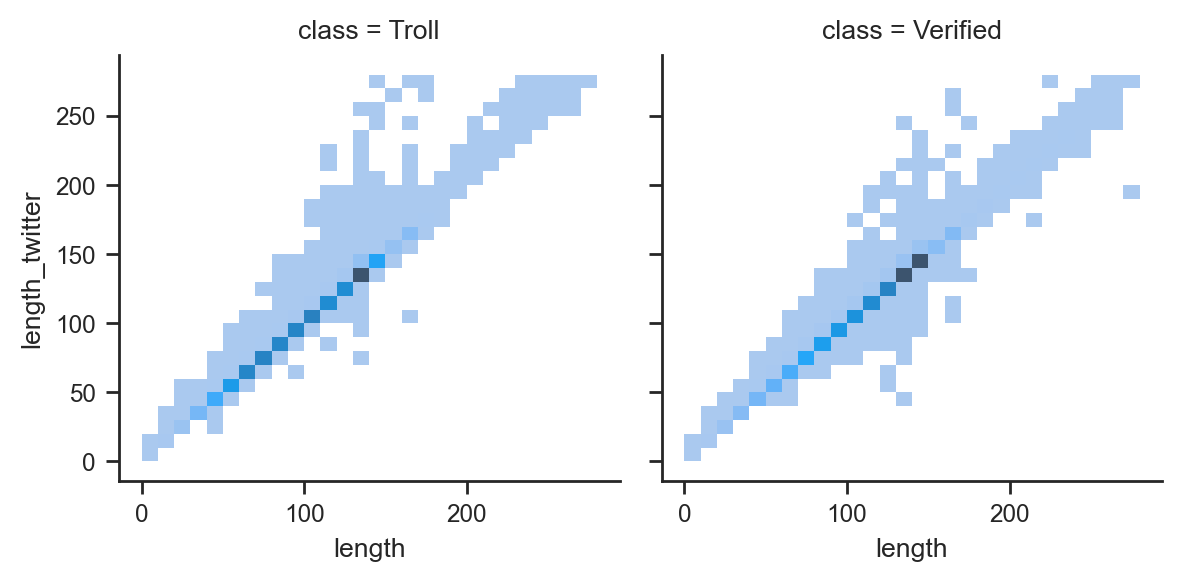

In [34]:
g = sns.FacetGrid(tweet_lengths, col='class')
g.map(sns.histplot, 'length', 'length_twitter', bins=28, binrange=(0,280), stat='density', common_norm=False, color=twitter_colors['blue'])

plt.show()

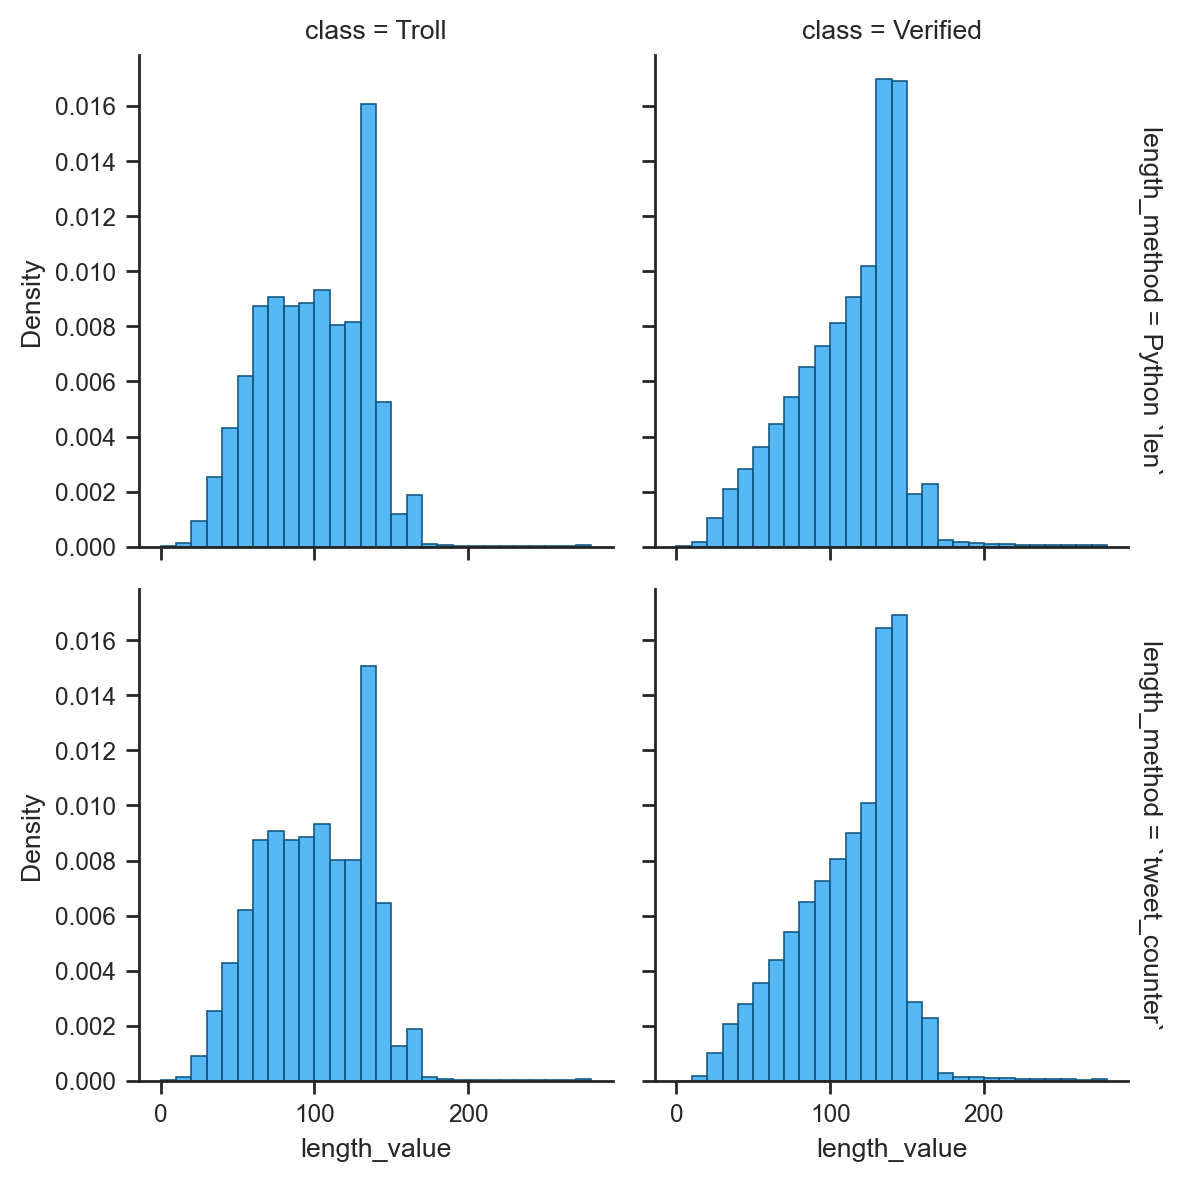

In [36]:
g = sns.FacetGrid(tweet_lengths_melted, row='length_method', col='class', margin_titles=True)
g.map(sns.histplot, 'length_value', bins=28, binrange=(0,280), stat='density', common_norm=False, 
        color=twitter_colors['blue'], edgecolor=twitter_colors['dark blue'])

plt.show()

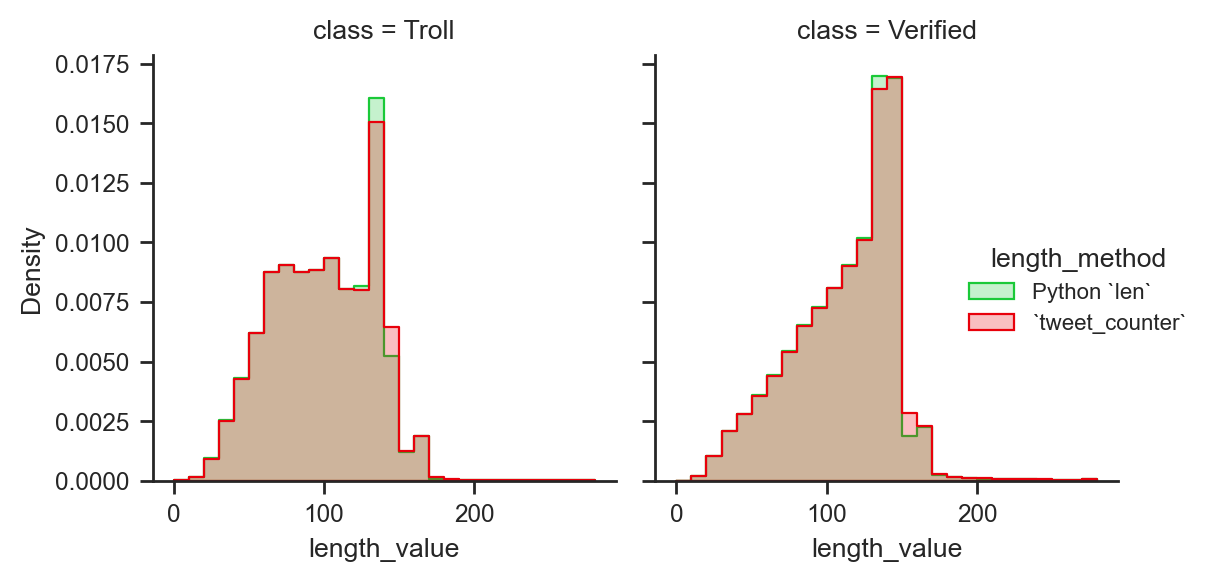

In [53]:
g = sns.FacetGrid(tweet_lengths_melted, 
                    hue='length_method', 
                    col='class', 
                    margin_titles=True, 
                    palette=sns.color_palette()[2:4]
                )
g.map(sns.histplot, 'length_value', 
        bins=28, 
        binrange=(0,280), 
        stat='density', 
        common_norm=False, 
        element='step', 
        alpha=0.25
    )

g.add_legend(bbox_to_anchor=(0.85, 0.5), loc='center right', borderaxespad=0, prop={'size': 8}, title=""None"")

plt.show()

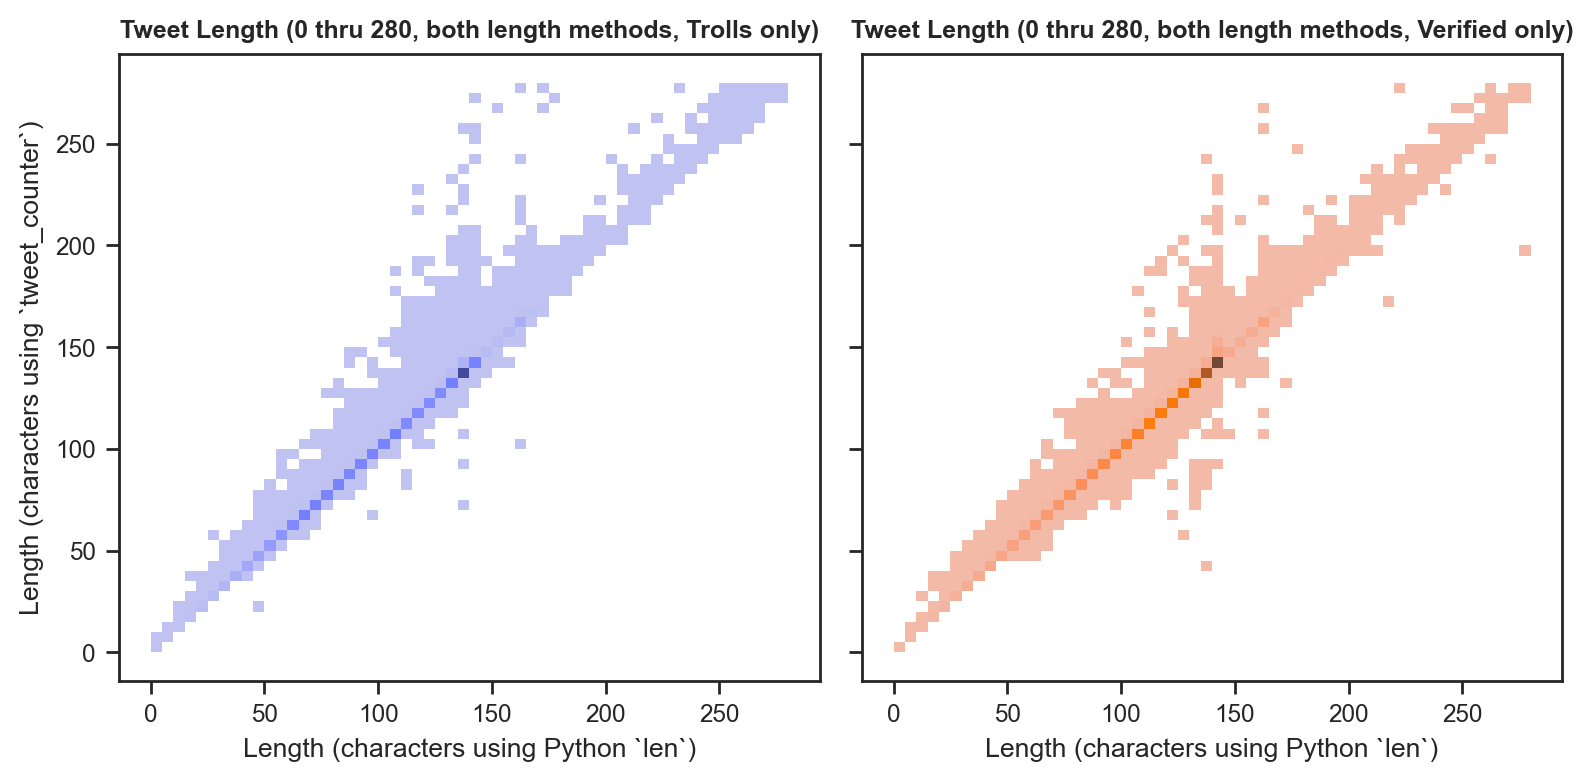

In [60]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True, layout="tight")

ax[0].set_title("Tweet Length (0 thru 280, both length methods, Trolls only)", weight='bold', size=9)
ax[0].set_xlabel("Length (characters using Python `len`)")
ax[0].set_ylabel("Length (characters using `tweet_counter`)")

ax[1].set_title("Tweet Length (0 thru 280, both length methods, Verified only)", weight='bold', size=9)
ax[1].set_xlabel("Length (characters using Python `len`)")

sns.histplot(tweet_lengths.loc[(tweet_lengths['length'].between(0,280)) & (tweet_lengths['class'] == 'Troll')],
                x='length',
                y='length_twitter',
                color=sns.color_palette()[0],
                bins=28*2,
                binrange=(0,280),
                stat='density',
                common_norm=False,
                ax=ax[0]
            )

sns.histplot(tweet_lengths.loc[(tweet_lengths['length'].between(0,280)) & (tweet_lengths['class'] == 'Verified')],
                x='length',
                y='length_twitter',
                color=sns.color_palette()[1],
                bins=28*2,
                binrange=(0,280),
                stat='density',
                common_norm=False,
                ax=ax[1]
            )

plt.show()

Further study is needed to understand why some tweets are logged with 800+ characters.

## 4.4 - Region (`region`)

In [61]:
# determine number of unique values
print(f"Unique `region` values: {len(merged_df['region'].unique().tolist()):,}")

Unique `region` values: 35,447


In [62]:
region_n_largest: pd.Series = merged_df.value_counts(subset='region', ascending=False).nlargest(15)

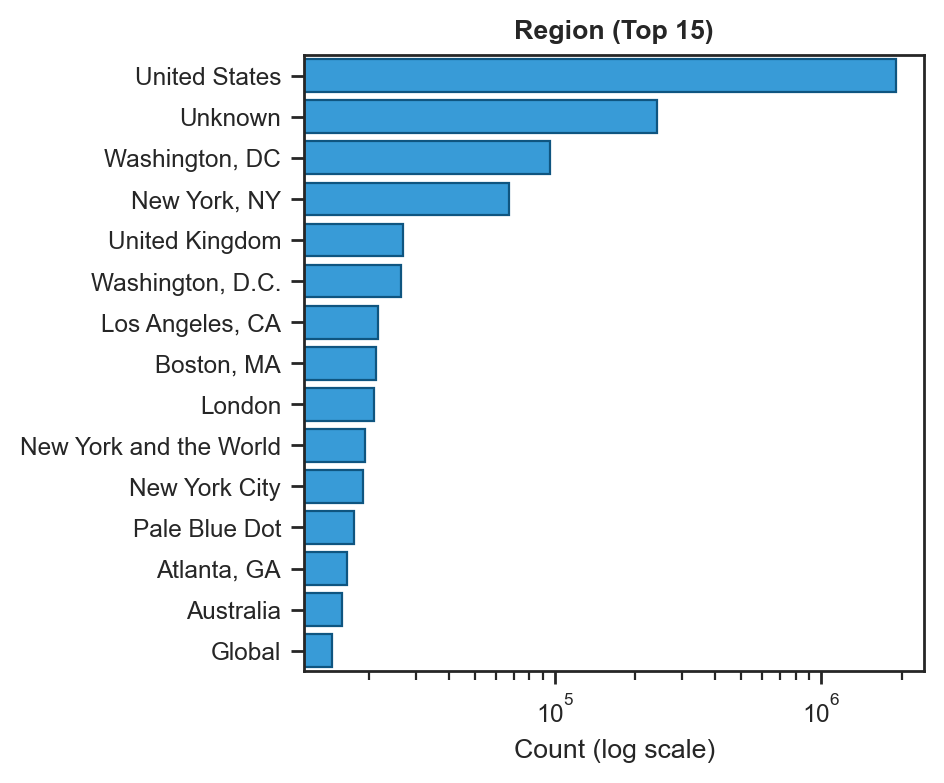

In [95]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(x=region_n_largest.values, 
            y=region_n_largest.index, 
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
            )

ax.set_xscale('log')
ax.set_title("Region (Top 15)", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)

plt.show()

In [65]:
region_df = merged_df[['region', 'data_source', 'class']].copy()

In [66]:
region_n_largest_df = region_df.loc[
                            region_df['region'].isin(region_n_largest.index), :
                        ].groupby(
                            by=['region', 'class']
                        ).count().rename(columns={'data_source': 'count'}).reset_index()

region_n_largest_df.head()

,region,class,count
0,"Atlanta, GA",Verified,16580
1,Australia,Verified,15804
2,"Boston, MA",Verified,21310
3,Global,Verified,14590
4,London,Verified,20968


In [80]:
region_n_largest_troll = region_df.loc[
                            region_df['class'] == "Troll"
                        ].groupby(
                            by=['region', 'class']
                        ).count().rename(columns={'data_source': 'count'}).reset_index().nlargest(15, columns='count')

region_n_largest_verif = region_df.loc[
                            region_df['class'] == "Verified"
                        ].groupby(
                            by=['region', 'class']
                        ).count().rename(columns={'data_source': 'count'}).reset_index().nlargest(15, columns='count')

region_n_largest_joined = pd.concat(
                            [region_n_largest_verif, region_n_largest_troll], 
                            ignore_index=True
                        ).sort_values(by='count', ascending=False)

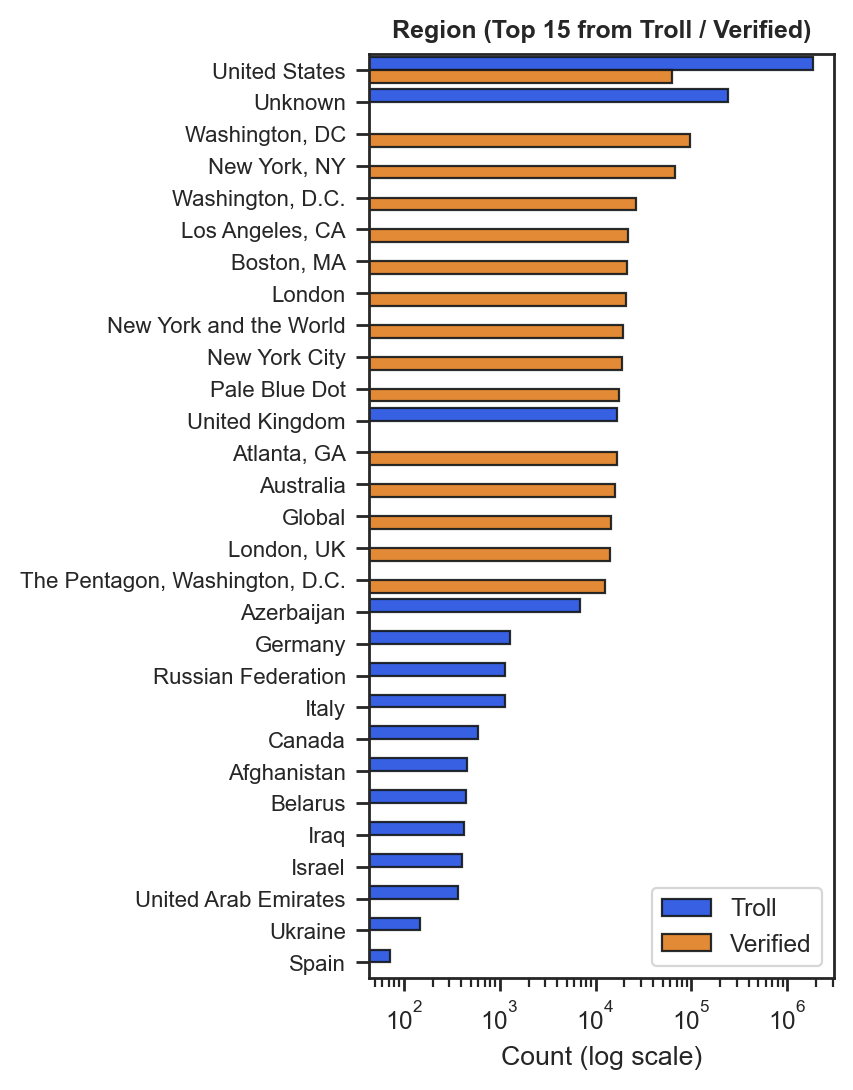

In [168]:
fig, ax = plt.subplots(figsize=(3,6))

sns.barplot(region_n_largest_joined,
            x='count', 
            y='region', 
            hue='class',
            hue_order=['Troll', 'Verified'],
            alpha=0.9,
            width=0.8,
            edgecolor=twitter_colors['black'],
            ax=ax
            )

ax.set_xscale('log')
ax.set_title("Region (Top 15 from Troll / Verified)", weight='bold', size=9)
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)

legend = ax.get_legend()
legend.set_title(None)

plt.tick_params(axis='y', labelsize=8)

plt.show()

## 4.5 - Language (`language`)

How many unique languages are contained within our dataset?

In [97]:
print(f"Number of unique languages:\t{merged_df['language'].nunique():,} unique languages")

Number of unique languages:	30 unique languages


In [98]:
merged_df['language'].unique().tolist()

['English',
 'en',
 'fr',
 'da',
 'de',
 'in',
 'it',
 'tl',
 'es',
 'pt',
 'ca',
 'cy',
 'nl',
 'pl',
 'zxx',
 'et',
 'no',
 'ht',
 'eu',
 'tr',
 'ro',
 'sv',
 'lv',
 'lt',
 'vi',
 'hi',
 'cs',
 'und',
 'ko',
 'hu']

### 4.5.1 - Combining English and en

In [99]:
merged_df['language'] = merged_df['language'].apply(lambda x: 'en' if x == 'English' else x)

The vast majority of our dataset are labeled with language "`en`" for English.

In [100]:
merged_df['language'].value_counts(ascending=False, dropna=False)

en     3623140
fr         397
tl         308
es         304
de         157
nl         117
in          83
pt          65
it          58
da          56
et          48
ht          43
eu          24
ca          18
sv          16
no          13
pl          12
cy          12
tr           4
lt           4
vi           4
lv           3
hu           2
ro           1
zxx          1
hi           1
cs           1
und          1
ko           1
Name: language, dtype: int64

In [101]:
print(f"Number of unique languages:\t{merged_df['language'].nunique():,} unique languages")

Number of unique languages:	29 unique languages


**Note** Eventually the non-english tweets will need to be dropped for the ML model, but for now they are retained for EDA. A separate df 'en_df' will be created for use later exploring the Russian tweets.

In [102]:
en_df = merged_df[merged_df['language']=='en'].copy()
en_df['language'].value_counts()

en    3623140
Name: language, dtype: int64

## 4.6 - Number of Accounts Following (`following`, other accounts followed by this one)

In [103]:
merged_df['following'].describe()

count    3.624894e+06
mean     5.616664e+03
std      3.305979e+04
min      0.000000e+00
25%      4.710000e+02
50%      1.431000e+03
75%      4.564000e+03
max      4.095338e+06
Name: following, dtype: float64

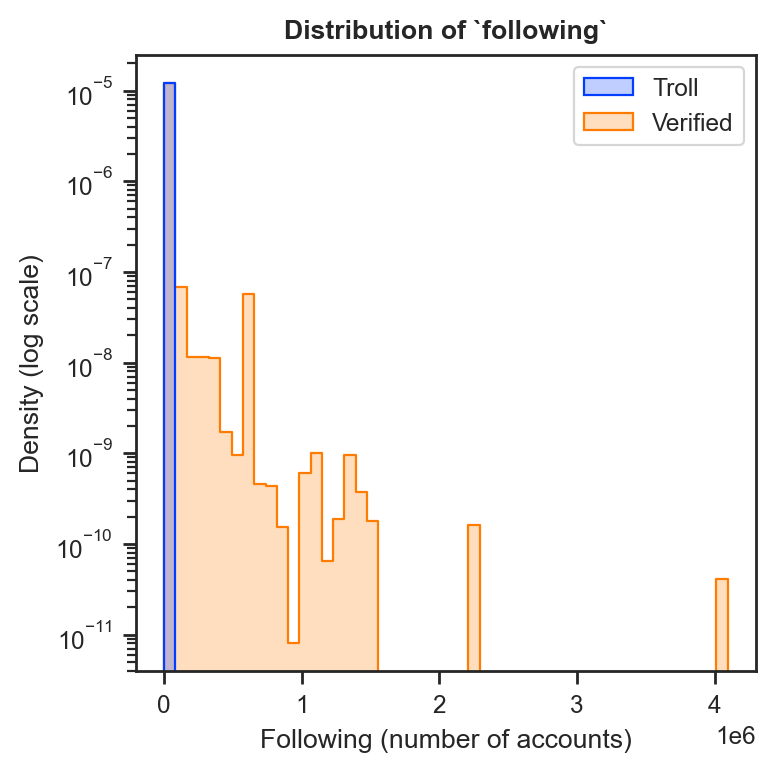

In [111]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `following`", weight='bold')
ax.set_xlabel("Following (number of accounts)")
ax.set_ylabel("Density (log scale)")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='following', 
                hue='class',
                bins=50,
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

The horizontal range of the above graph is surprisingly large, but note that the step down from the first bin to second bin is over two ordered of magnitude. The vast majority of accounts, both Troll and Verified, follow a small number of other accounts.

In [112]:
median_following: pd.DataFrame = merged_df.groupby(['account_category'])['following'].median() \
                                .to_frame().reset_index().sort_values(by='following')

median_following

,account_category,following
0,Commercial,3.0
1,Fearmonger,65.0
5,NonEnglish,255.0
7,Unknown,515.0
3,LeftTroll,796.0
8,Verified_User,995.0
6,RightTroll,1867.0
2,HashtagGamer,2622.0
4,NewsFeed,7090.0


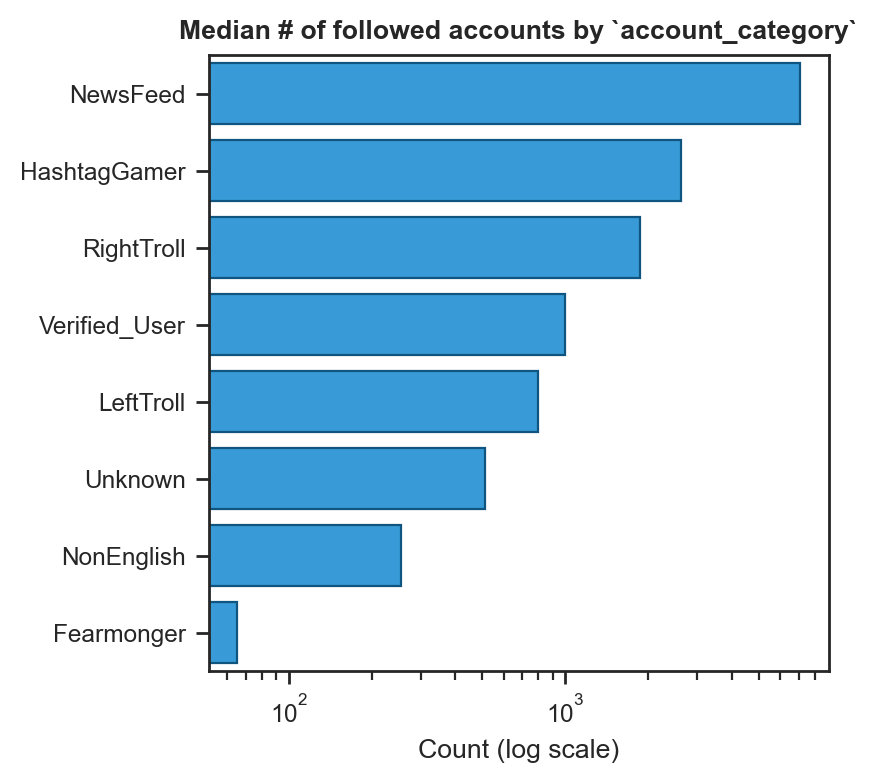

In [115]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(median_following.nlargest(8, columns='following').sort_values(by='following', ascending=False),
            x='following', 
            y='account_category', 
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
        )

#ax.set_xscale('log')
ax.set_title("Median # of followed accounts by `account_category`", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)
ax.set_xscale("log")

plt.show()

## 4.7 - Number of Followers (`followers`, other accounts following this one)

In [116]:
merged_df['followers'].describe()

count    3.624894e+06
mean     1.744430e+06
std      9.483849e+06
min      0.000000e+00
25%      1.140000e+03
50%      1.138500e+04
75%      5.856000e+04
max      1.335241e+08
Name: followers, dtype: float64

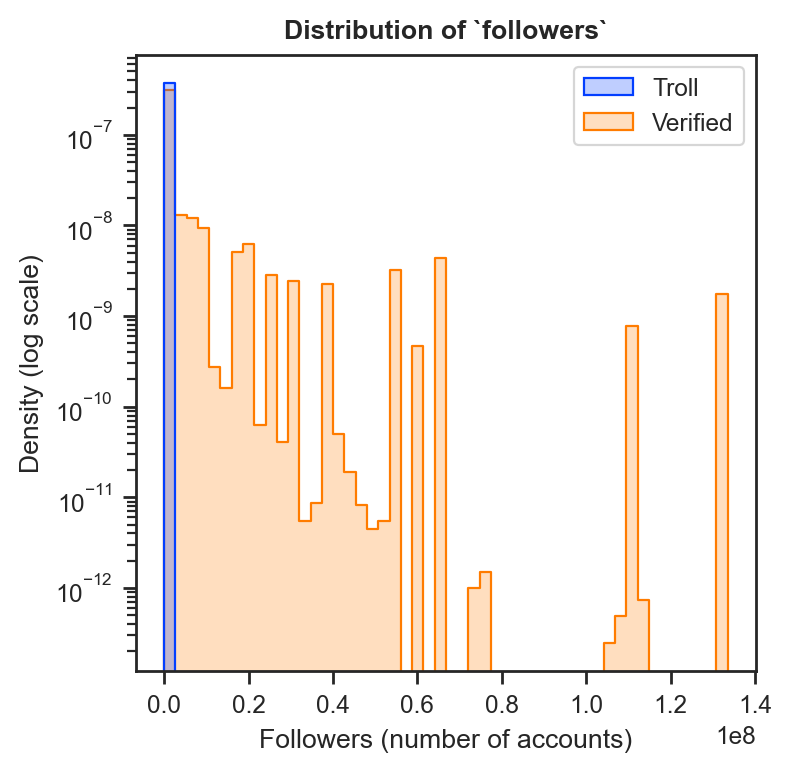

In [120]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `followers`", weight='bold')
ax.set_xlabel("Followers (number of accounts)")
ax.set_ylabel("Density (log scale)")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='followers', 
                hue='class',
                bins=50,
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

In [121]:
median_followers: pd.DataFrame = merged_df.groupby(['account_category'])['followers'].median() \
                                .to_frame().reset_index().sort_values(by='followers')

median_followers

,account_category,followers
1,Fearmonger,48.0
0,Commercial,262.0
5,NonEnglish,335.0
3,LeftTroll,836.0
6,RightTroll,1436.0
2,HashtagGamer,2484.0
7,Unknown,9311.0
4,NewsFeed,14725.0
8,Verified_User,81833.0


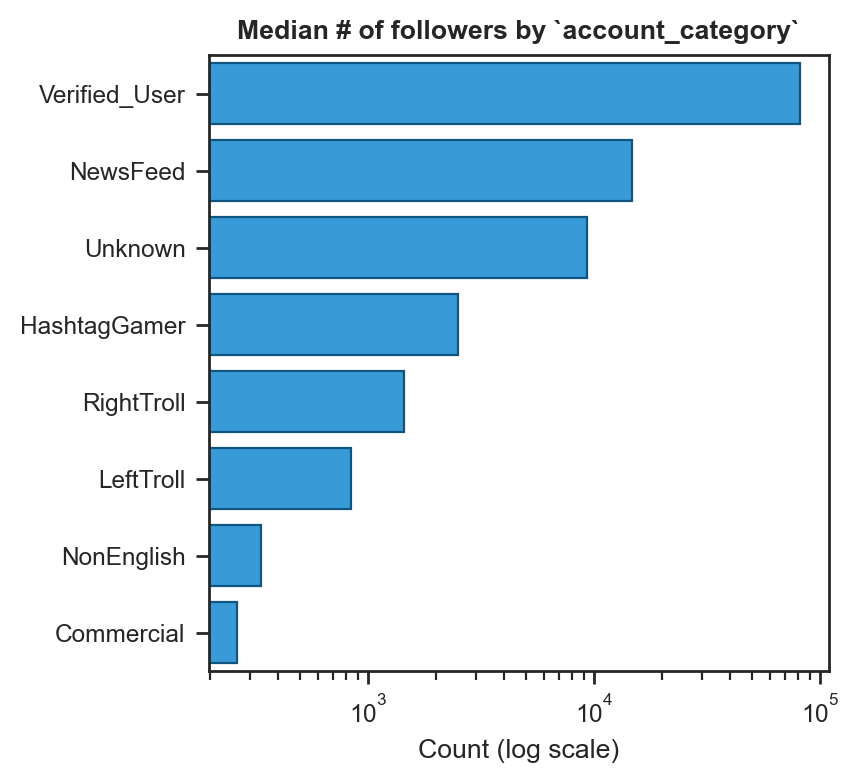

In [123]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(median_followers.nlargest(8, columns='followers').sort_values(by='followers', ascending=False),
            x='followers', 
            y='account_category', 
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
        )

#ax.set_xscale('log')
ax.set_title("Median # of followers by `account_category`", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)
ax.set_xscale("log")

plt.show()

## 4.8 - Number of Update Actions (`updates`)

In [124]:
merged_df['updates'].describe()

count    3.624894e+06
mean     6.779971e+03
std      1.945427e+04
min      0.000000e+00
25%      1.000000e+01
50%      1.085000e+03
75%      6.200000e+03
max      5.732199e+06
Name: updates, dtype: float64

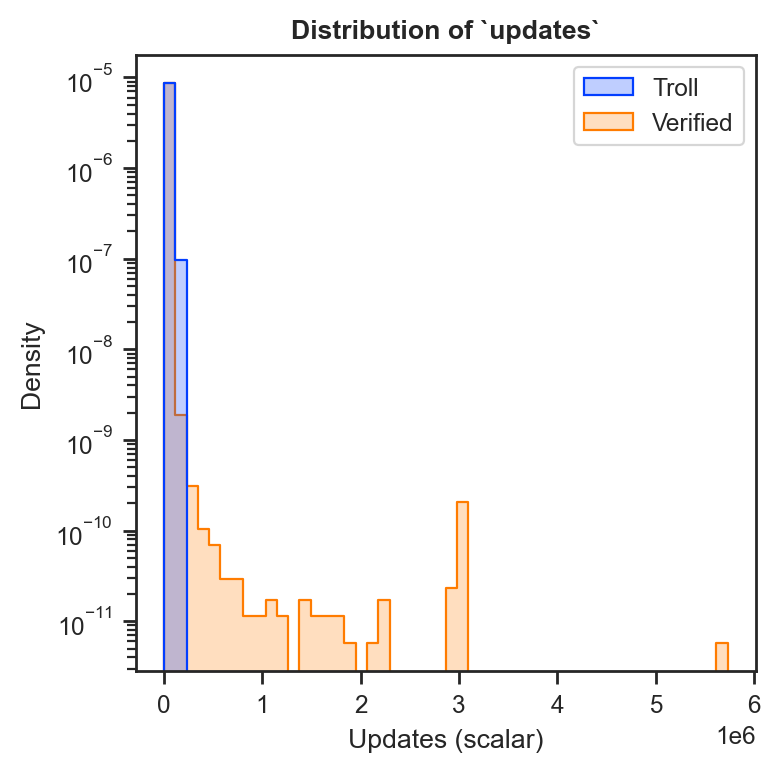

In [126]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `updates`", weight='bold')
ax.set_xlabel("Updates (scalar)")
ax.set_ylabel("Density")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='updates', 
                hue='class',
                bins=50,
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

## 4.9 - Retweet (`is_retweet`)

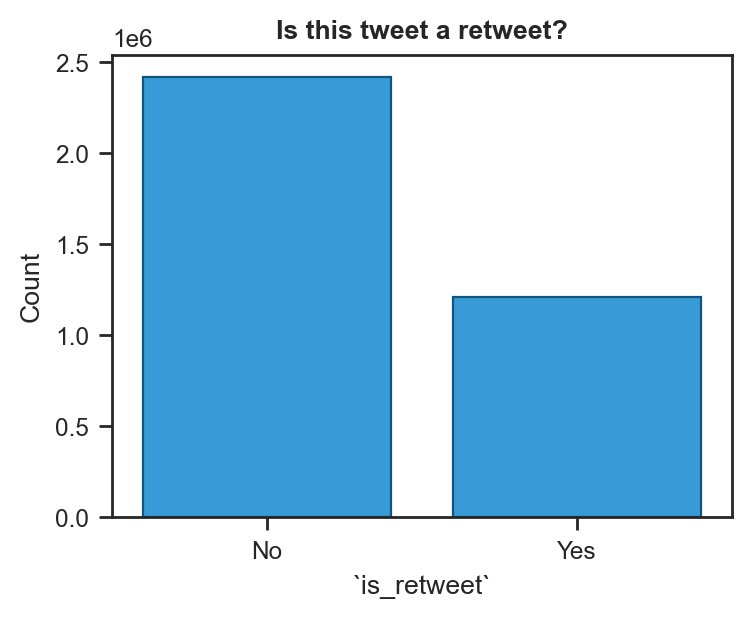

In [144]:
fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(merged_df['is_retweet'].value_counts().to_frame(),
            x=merged_df['is_retweet'].value_counts().index, 
            y=merged_df['is_retweet'].value_counts().values,
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
        )

ax.set_title("Is this tweet a retweet?", weight='bold')
ax.set_xlabel("`is_retweet`")
ax.set_ylabel("Count")
ax.set_xticks(ticks=[0.0, 1.0], labels=['No', 'Yes'])

plt.show()

In [158]:
is_retweet: pd.DataFrame = merged_df.groupby(['is_retweet', 'class'])[['class']].count() \
                            .rename(columns={"class": "count"}).reset_index()

is_retweet.replace({'is_retweet': {0: 'No', 1: 'Yes'}}, inplace=True)

# normalize based on class size
is_retweet.loc[is_retweet['class'] == "Troll", 'count_normalized'] = \
    is_retweet.loc[is_retweet['class'] == "Troll", 'count'] / is_retweet.loc[is_retweet['class'] == "Troll", 'count'].sum()
    
is_retweet.loc[is_retweet['class'] == "Verified", 'count_normalized'] = \
    is_retweet.loc[is_retweet['class'] == "Verified", 'count'] / is_retweet.loc[is_retweet['class'] == "Verified", 'count'].sum()

is_retweet

,is_retweet,class,count,count_normalized
0,No,Troll,1264330,0.597265
1,No,Verified,1154664,0.765678
2,Yes,Troll,852536,0.402735
3,Yes,Verified,353364,0.234322


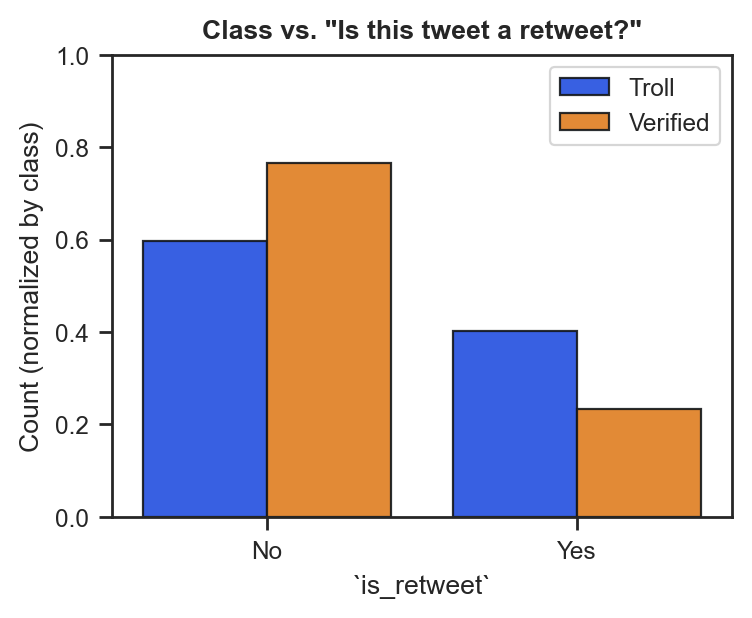

In [165]:
fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(is_retweet,
            x='is_retweet', 
            y='count_normalized', 
            hue='class',
            alpha=0.9,
            edgecolor=twitter_colors['black'],
            ax=ax
        )

ax.set_title("Class vs. \"Is this tweet a retweet?\"", weight='bold')
ax.set_xlabel("`is_retweet`")
ax.set_ylabel("Count (normalized by class)")
ax.set_ylim((0,1))

legend = ax.get_legend()
legend.set_title(None)

plt.show()

## 4.10 - Account Category (`account_category`)

In [169]:
account_category: pd.DataFrame = merged_df['account_category'].value_counts(dropna=False, ascending=True) \
                                .to_frame().reset_index().rename(
                                    columns={'index': 'account_category', 'account_category': 'count'}
                                )

account_category

,account_category,count
0,Fearmonger,11001
1,NonEnglish,26562
2,Unknown,43252
3,Commercial,112580
4,HashtagGamer,236091
5,LeftTroll,422141
6,NewsFeed,596593
7,RightTroll,704953
8,Verified_User,1471721


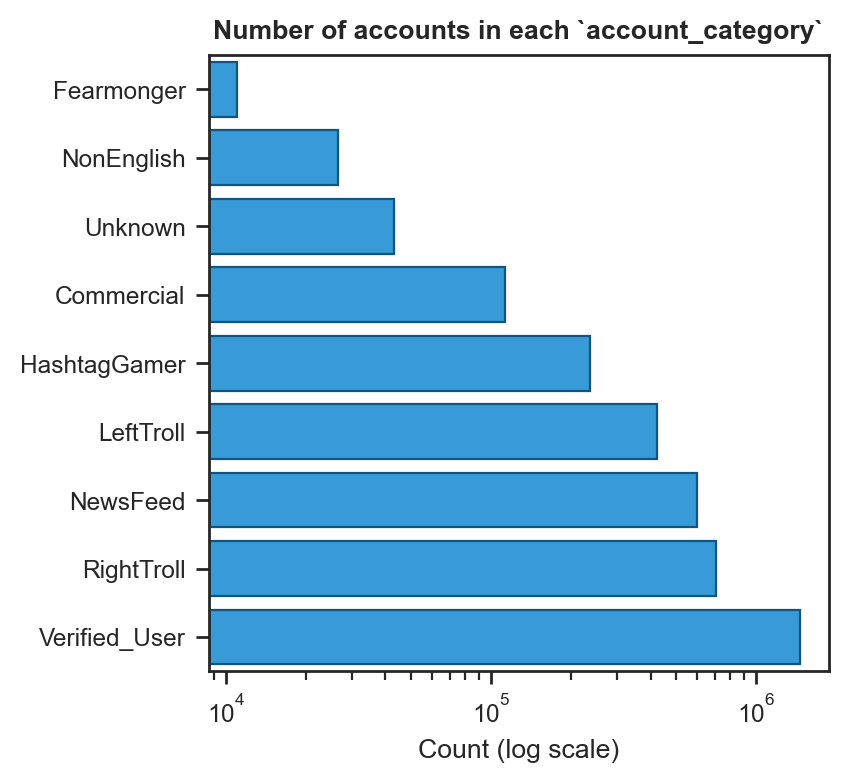

In [172]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(account_category,
            x='count', 
            y='account_category', 
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
        )

ax.set_title("Number of accounts in each `account_category`", weight='bold')
ax.set_xlabel("Count (log scale)")
ax.set_ylabel(None)
ax.set_xscale("log")

plt.show()

## 4.11 - Tweet ID (`tweet_id`)

The `tweet_id` feature is a unique identifier for each Tweet, and is automatically generated by Twitter. Because this feature is randomized, and because it is not able to be set/edited/influenced by the user, we do not need to conduct any analysis of it.

## 4.12 - First URL from within Tweet Content (`tco1_step1`)

In [173]:
url_pieces: pd.DataFrame = merged_df[['tco1_step1', 'class']].copy()

url_pieces['domain'] = url_pieces.loc[url_pieces['tco1_step1'].notna(), 'tco1_step1'] \
                        .apply(lambda s: tur.explode_url(s)['domain'])

In [175]:
url_pieces['domain'].value_counts().nlargest(20)

twitter            1112469
bit                 181706
ift                  42050
ow                   41952
usa                  37624
fb                   31311
instagram            25614
bloom                18843
youtube              18635
zpr                  17023
hill                 16180
trib                 16060
youtu                14213
wsj                  12773
goo                  11761
reut                 11118
dlvr                 10932
EXERCISEWORKOUT      10564
EXERCISEQUOTE         9883
bbc                   9574
Name: domain, dtype: int64

In [174]:
url_pieces['tld'] = url_pieces.loc[url_pieces['tco1_step1'].notna(), 'tco1_step1'] \
                        .apply(lambda s: tur.explode_url(s)['tld'])

In [176]:
url_pieces['tld'].value_counts().nlargest(20)

com      1413853
ly        243041
gov        74422
me         44396
tt         42313
io         22855
PW         21208
org        20083
co         19513
al         19493
bg         18953
cm         17397
ws         16913
it         16579
co.uk      14674
be         14320
ms         12088
gl         11935
rs         11464
tv          9751
Name: tld, dtype: int64

In [181]:
url_pieces.groupby(by=['class', 'domain'])['domain'].value_counts().nlargest(20)

class     domain           domain         
Troll     twitter          twitter            921908
Verified  twitter          twitter            190561
Troll     bit              bit                 99815
Verified  bit              bit                 81891
Troll     ift              ift                 39820
Verified  usa              usa                 37464
          ow               ow                  30624
          fb               fb                  20254
          bloom            bloom               18630
          instagram        instagram           17353
Troll     zpr              zpr                 16893
Verified  hill             hill                16167
          trib             trib                13086
          wsj              wsj                 12006
Troll     ow               ow                  11328
          fb               fb                  11057
Verified  reut             reut                10791
Troll     EXERCISEWORKOUT  EXERCISEWORKOUT     10564
   

## 4.13 - Data Source (`data_source`)

In [225]:
data_source: pd.DataFrame = merged_df['data_source'].value_counts().to_frame(name='count').reset_index(names='data_source')

data_source['label'] = data_source.apply(lambda row: f"\"{row['data_source']}\"\n{row['count']:,}", axis='columns')

data_source 

,data_source,count,label
0,Troll,2116866,"""Troll""\n2,116,866"
1,verified_random,1070661,"""verified_random""\n1,070,661"
2,verified_user,437367,"""verified_user""\n437,367"


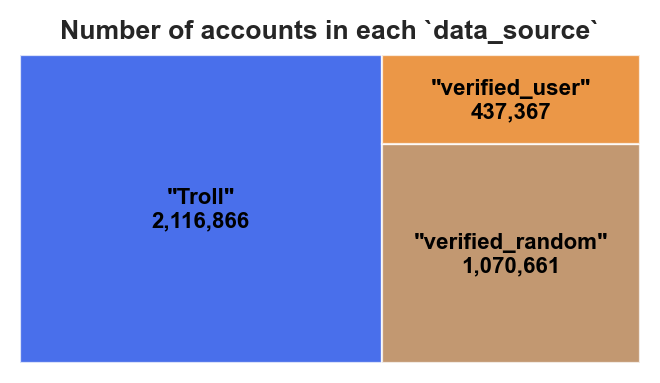

In [237]:
fig, ax = plt.subplots(figsize=(4,2))

data_source_color_dict = {
    'Troll': sns.color_palette(desat=0.8)[0],
    'verified_user': sns.color_palette(desat=0.8)[1],
    'verified_random': sns.color_palette(desat=0.4)[1]
}

squarify.plot(
    sizes=data_source['count'],
    label=data_source['label'],
    color=[data_source_color_dict[ds] for ds in data_source['data_source'].values],
    alpha=0.8,
    ax=ax,
    text_kwargs={'size': 8, 'weight': 'semibold', 'color': 'black'}
    )

ax.set_title("Number of accounts in each `data_source`", weight='bold')
plt.axis('off')
plt.show()

<AxesSubplot: title={'center': 'Data Source Counts'}>

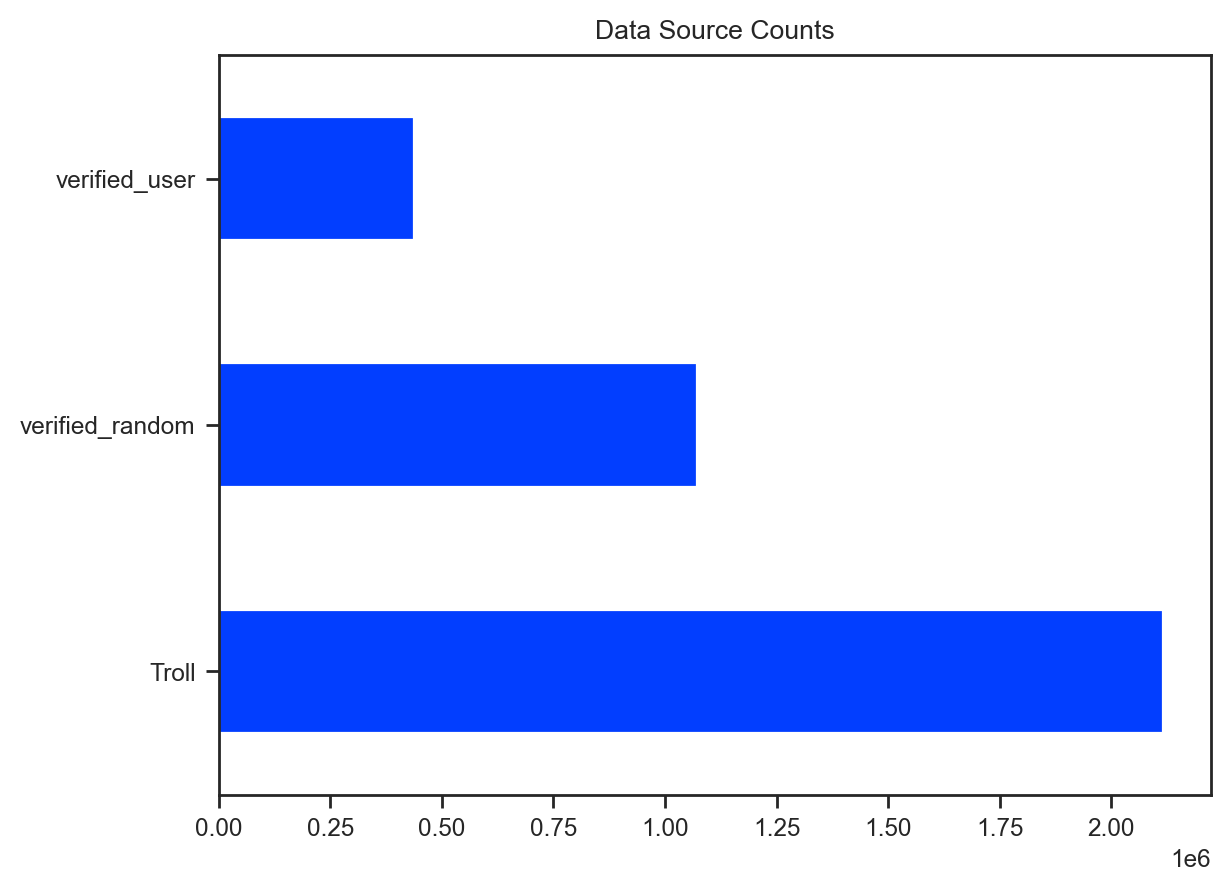

In [238]:
merged_df.data_source.value_counts().plot(kind='barh',title='Data Source Counts')

## 4.14 - Tweet Has URL (`has_url`)

In [240]:
merged_df['has_url'].value_counts()

1    2266295
0    1358599
Name: has_url, dtype: int64

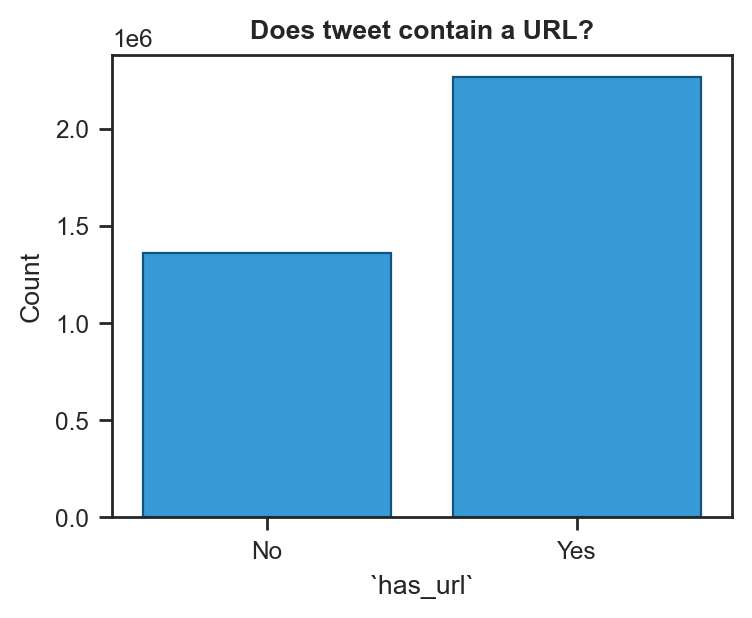

In [239]:
fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(merged_df['has_url'].value_counts().to_frame(),
            x=merged_df['has_url'].value_counts().index, 
            y=merged_df['has_url'].value_counts().values,
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
        )

ax.set_title("Does tweet contain a URL?", weight='bold')
ax.set_xlabel("`has_url`")
ax.set_ylabel("Count")
ax.set_xticks(ticks=[0.0, 1.0], labels=['No', 'Yes'])

plt.show()

## 4.15 - Emoji Text (`emoji_text`)

A basic analysis of emoji text (pure-text representations of emoji characters) is conducted in the next section as part of the `emoji_count` analysis.

## 4.16 - Number of Emoji (`emoji_count`)

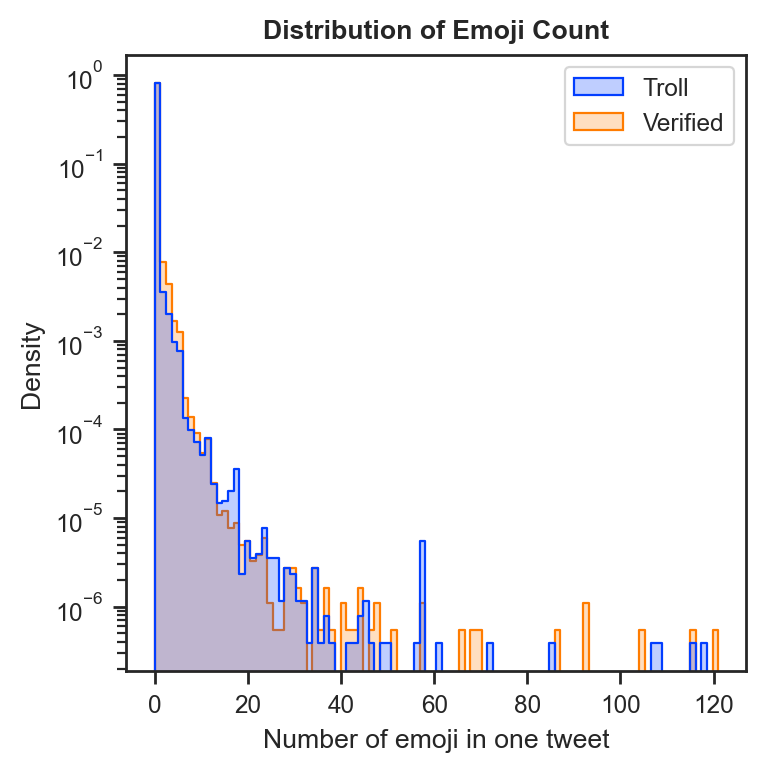

In [243]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of Emoji Count", weight='bold')
ax.set_xlabel("Number of emoji in one tweet")
ax.set_ylabel("Density")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='emoji_count', 
                hue='class',
                bins=100,
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

### 4.16.1 Emoji Counts for entire dataset

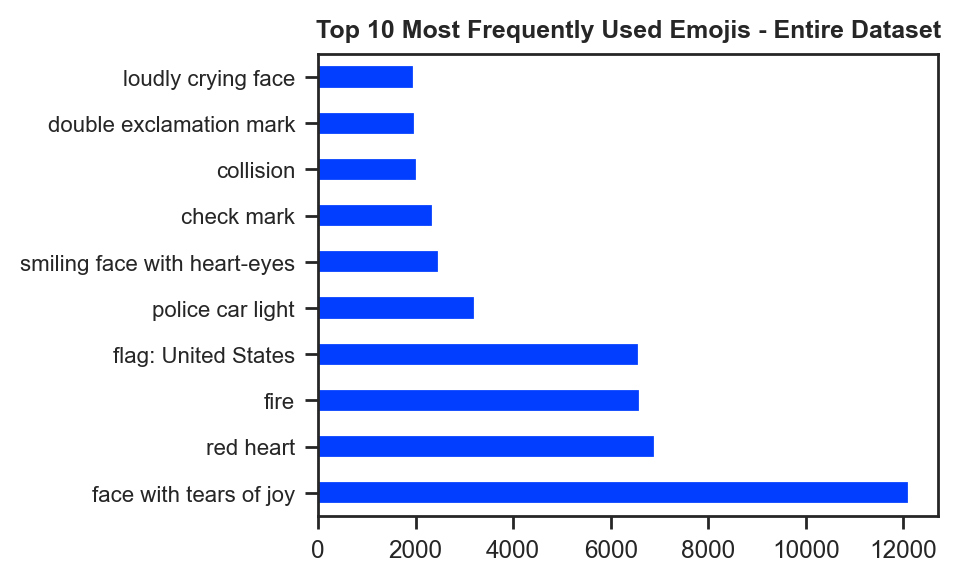

In [27]:
#Entire dataset
list_emojis = tur.capture_emojis_list(merged_df['emoji_text'])
flat_list = tur.flatten_emoji_list(list_emojis)

fig, ax = plt.subplots(figsize=(4,3))

tur.print_emoji_top_10(flat_list)

plt.tick_params(axis='y', labelsize=8)
plt.title("Top 10 Most Frequently Used Emojis - Entire Dataset", weight='bold', size=9)
plt.show()

### 4.16.2 Emoji Counts for Verified Users/Random

In [28]:
# Non-Troll Emojis
non_troll_emojis_series = merged_df[merged_df['data_source']!='Troll']['emoji_text']

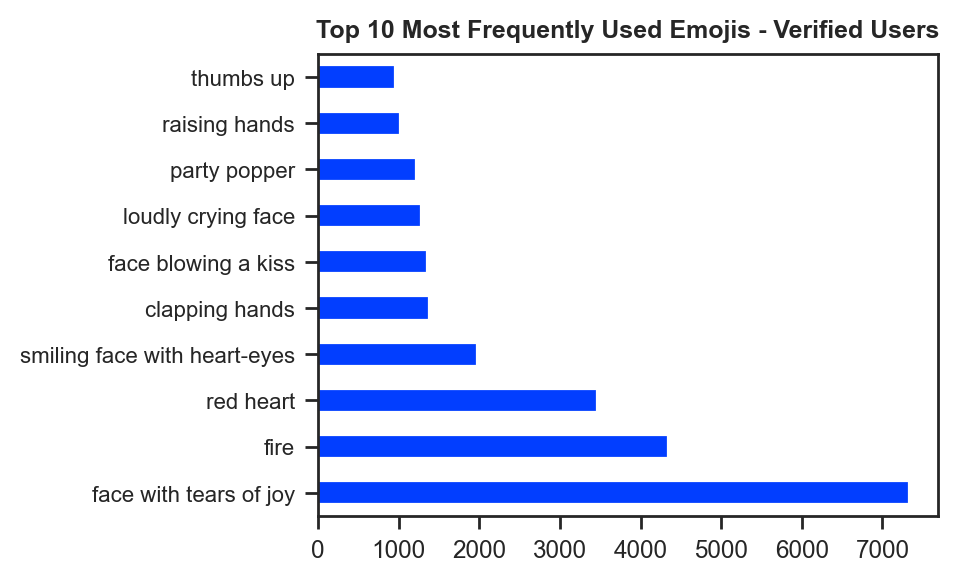

In [29]:
list_emojis1 = tur.capture_emojis_list(non_troll_emojis_series)
flat_list1 = tur.flatten_emoji_list(list_emojis1)

fig, ax = plt.subplots(figsize=(4,3))

tur.print_emoji_top_10(flat_list1)

plt.tick_params(axis='y', labelsize=8)
plt.title("Top 10 Most Frequently Used Emojis - Verified Users", weight='bold', size=9)
plt.show()

### 4.16.3 Emojis Counts for Trolls

In [30]:
troll_emojis_series = merged_df[merged_df['data_source']=='Troll']['emoji_text']

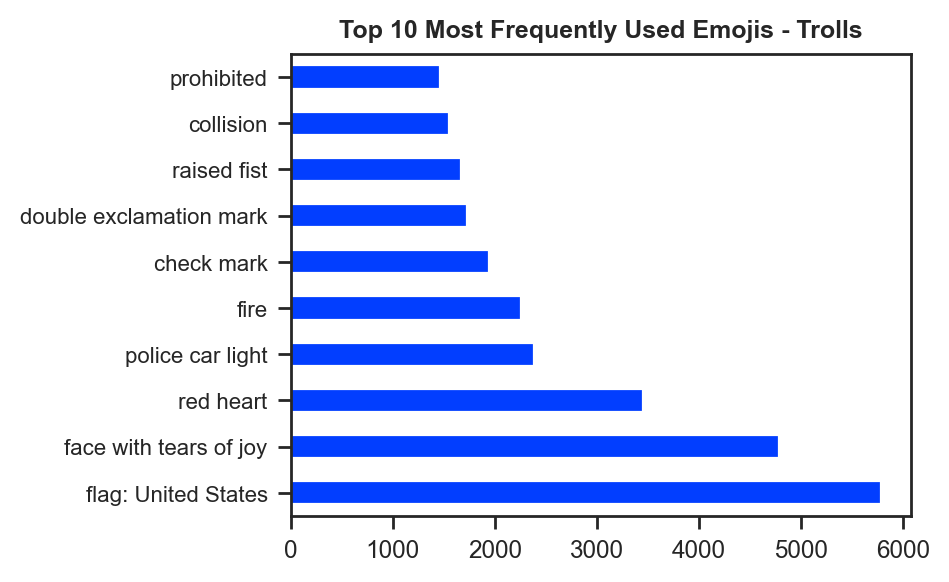

In [31]:
list_emojis2 = tur.capture_emojis_list(troll_emojis_series)
flat_list2 = tur.flatten_emoji_list(list_emojis2)

fig, ax = plt.subplots(figsize=(4,3))

tur.print_emoji_top_10(flat_list2)

plt.tick_params(axis='y', labelsize=8)
plt.title("Top 10 Most Frequently Used Emojis - Trolls", weight='bold', size=9)
plt.show()

## 4.17 - Publish Date of Tweet (`publish_date`)

In [278]:
# determine timeline of tweets
min_time = merged_df['publish_date'].min()
max_time = merged_df['publish_date'].max()

print(f"TIMELINE: {min_time:%Y-%m-%d %H:%M} to {max_time:%Y-%m-%d %H:%M}")

TIMELINE: 2012-02-06 20:24 to 2018-05-30 20:58


# 5 - Features (Multvariate Analysis)

## 5.1 Data Source vs...

### 5.1.1  Updates

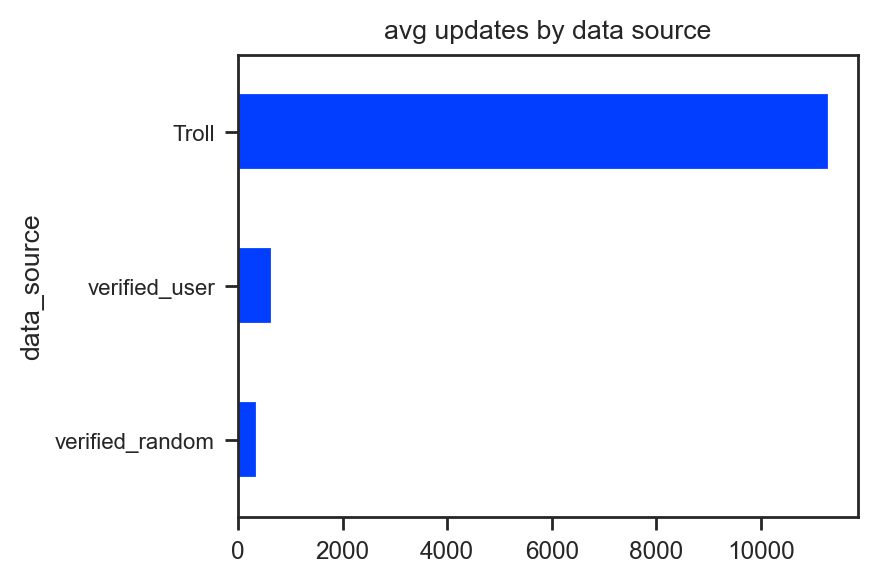

In [312]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['data_source'])['updates'].mean().sort_values().plot(kind='barh',title='avg updates by data source')

plt.tick_params(axis='y', labelsize=8)
plt.show()

### 5.1.2 Region

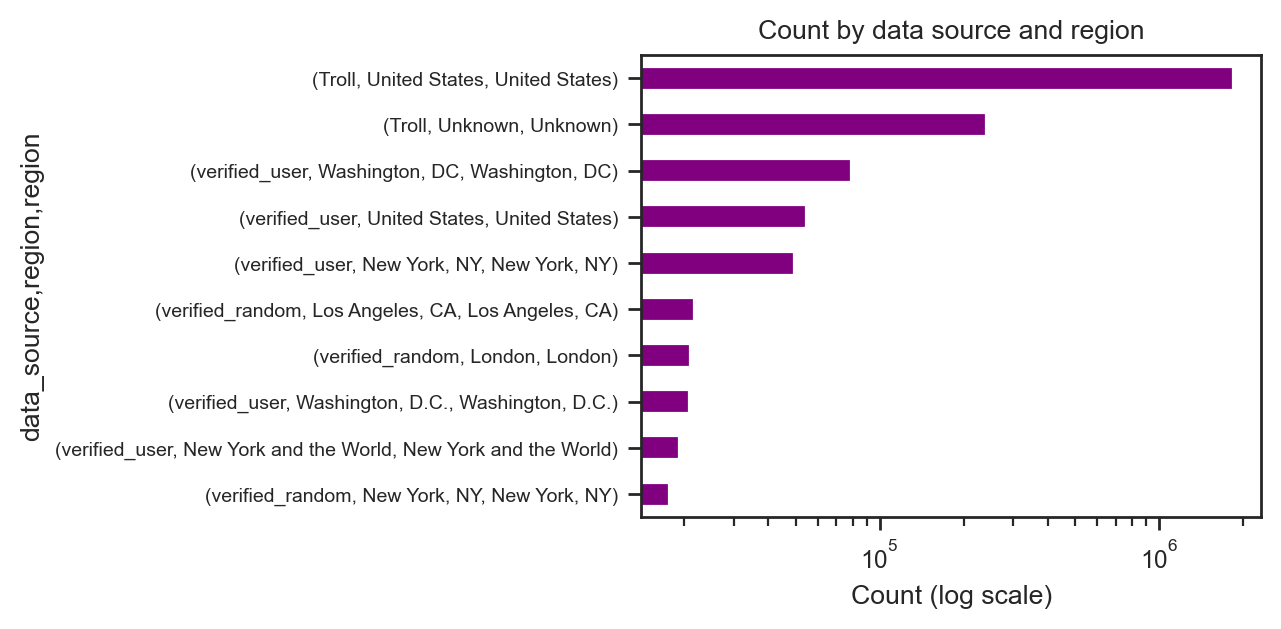

In [311]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['data_source','region'])['region'].value_counts().nlargest(10).sort_values() \
    .plot(kind='barh', title='Count by data source and region', color = 'purple')

ax.set_xscale("log")
ax.set_xlabel("Count (log scale)")

plt.tick_params(axis='y', labelsize=7)
plt.show()

### 5.1.3 Region and Author

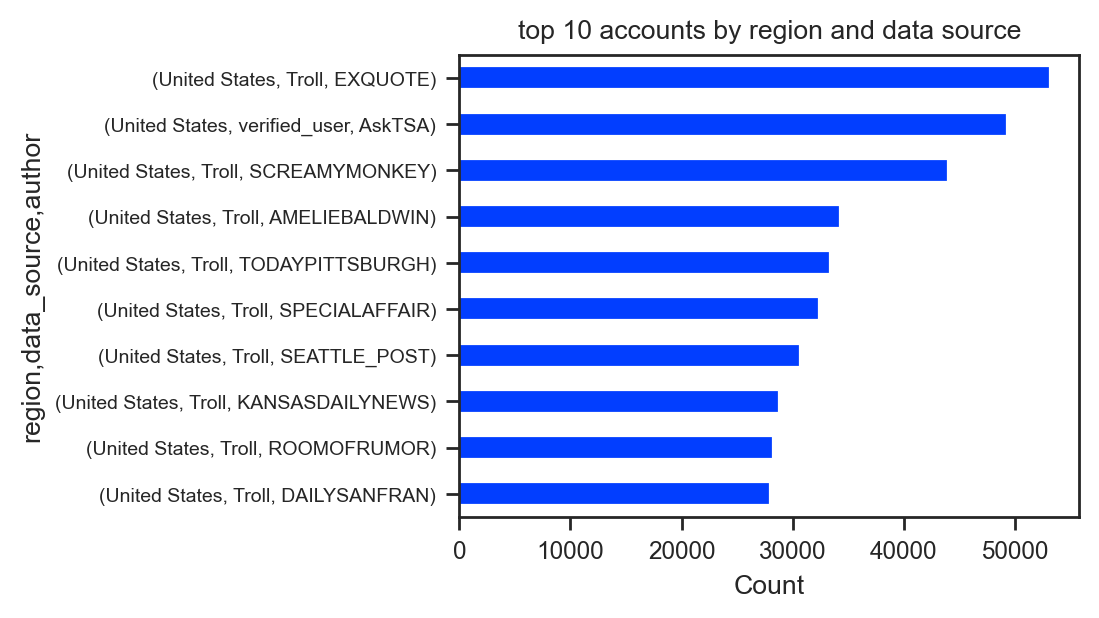

In [310]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['region','data_source'])['author'].value_counts().nlargest(10).sort_values() \
    .plot(kind='barh', title='top 10 accounts by region and data source')

ax.set_xlabel("Count")

plt.tick_params(axis='y', labelsize=7)
plt.show()

### 5.1.4 Emoji Count and Author

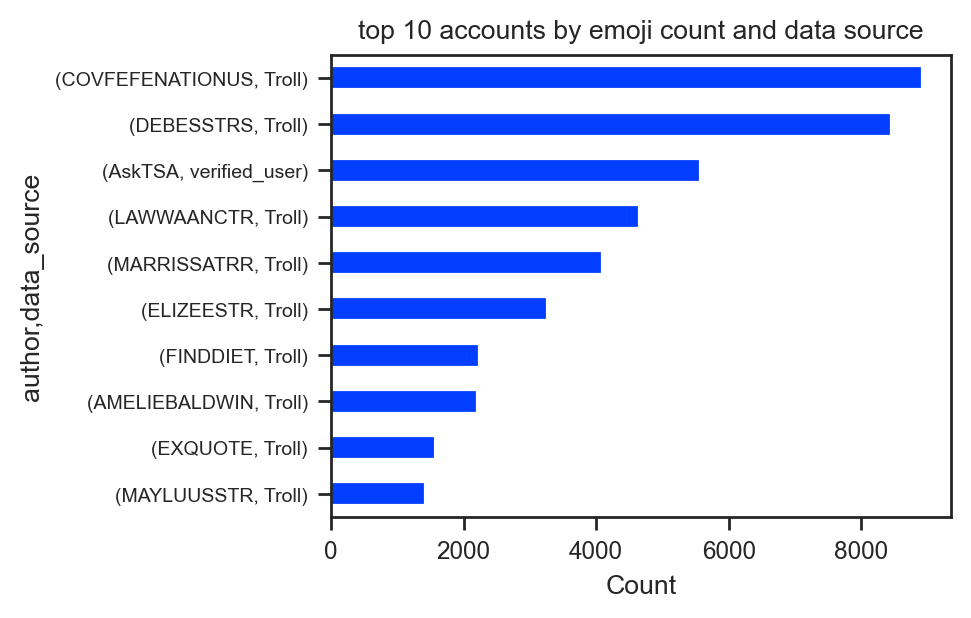

In [309]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['author','data_source'])['emoji_count'].sum().nlargest(10).sort_values() \
    .plot(kind='barh',title='top 10 accounts by emoji count and data source')

ax.set_xlabel("Count")

plt.tick_params(axis='y', labelsize=7)
plt.show()

## 5.2 Account Category vs...

### 5.2.1 Following

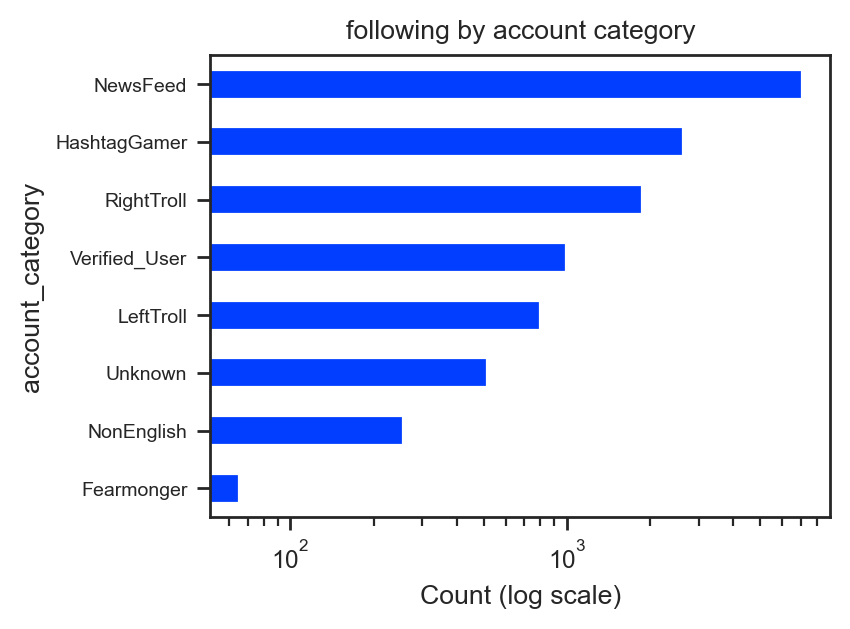

In [308]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['account_category'])['following'].median().nlargest(8).sort_values() \
    .plot(kind='barh', title='following by account category')

ax.set_xlabel("Count (log scale)")
ax.set_xscale("log")

plt.tick_params(axis='y', labelsize=7)
plt.show()

### 5.2.2 Followers

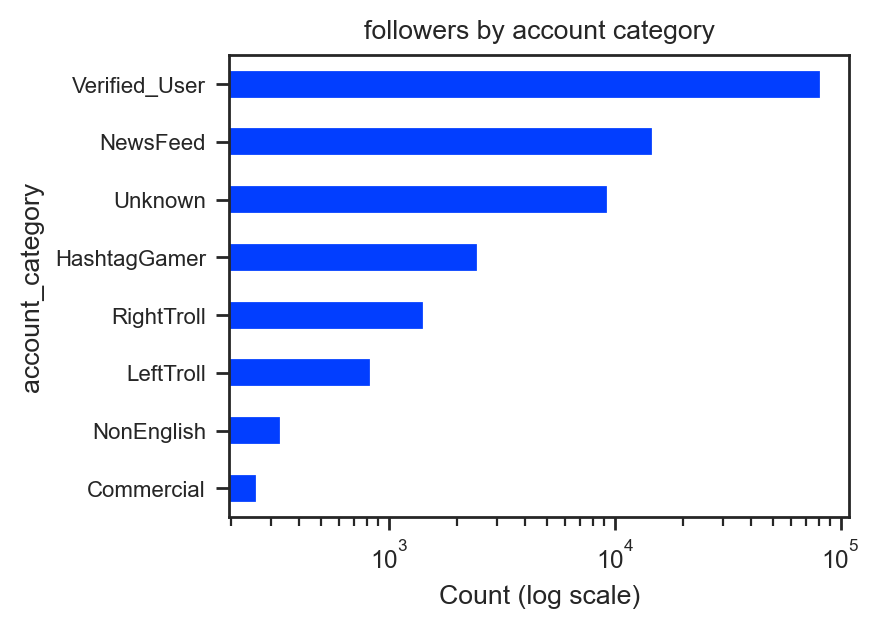

In [307]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['account_category'])['followers'].median().nlargest(8).sort_values() \
    .plot(kind='barh', title='followers by account category')

ax.set_xlabel("Count (log scale)")
ax.set_xscale("log")

plt.tick_params(axis='y', labelsize=8)
plt.show()

### 5.2.3 Following Ratio

Following Ratio is calculated within this section and compared against `account_category`. A later section compares against `class`.

In [297]:
merged_df['following_ratio'] = (merged_df['following'] + 0) / (merged_df['followers'] + 1)

merged_df['following_ratio'].describe()

count    3.624894e+06
mean     9.045287e-01
std      4.824604e+00
min      0.000000e+00
25%      1.562500e-02
50%      3.870923e-01
75%      9.384776e-01
max      1.010000e+03
Name: following_ratio, dtype: float64

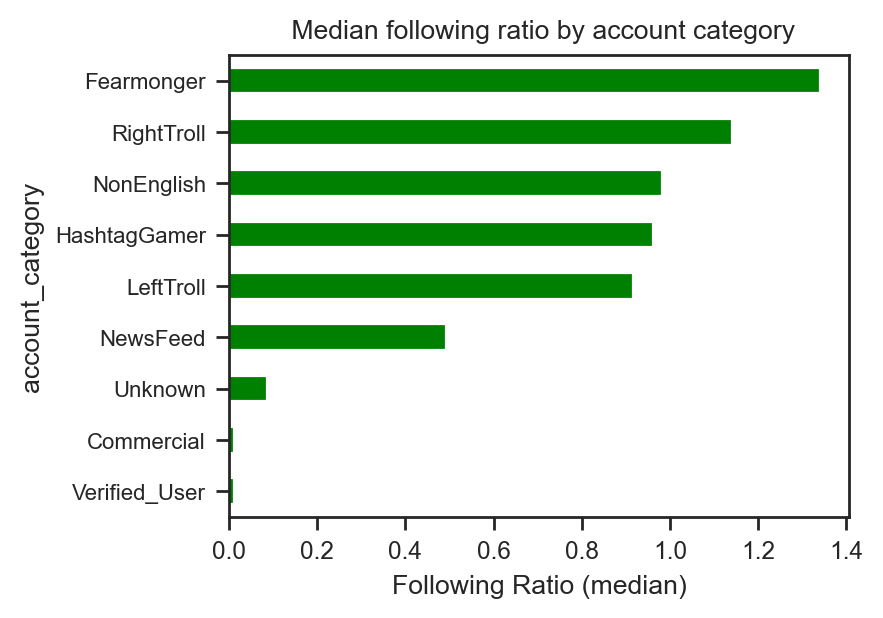

In [305]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['account_category'])['following_ratio'].median().sort_values() \
    .plot(kind='barh', title=' Median following ratio by account category', color = 'green')

ax.set_xlabel("Following Ratio (median)")

plt.tick_params(axis='y', labelsize=8)
plt.show()

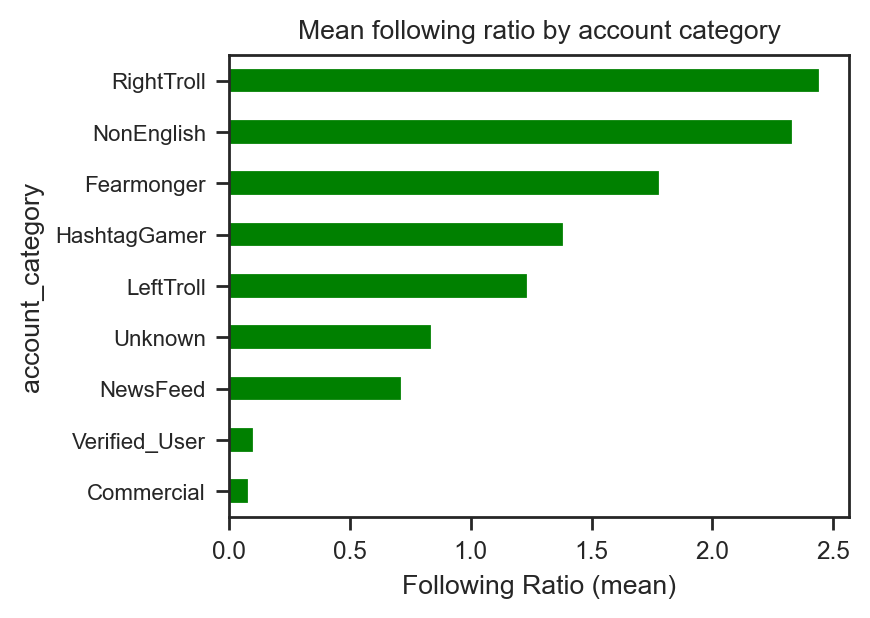

In [304]:
fig, ax = plt.subplots(figsize=(4,3))

merged_df.groupby(['account_category'])['following_ratio'].mean().sort_values() \
    .plot(kind='barh',title='Mean following ratio by account category', color = 'green')

ax.set_xlabel("Following Ratio (mean)")

plt.tick_params(axis='y', labelsize=8)
plt.show()

## 5.3 Correlation Heatmap

In [ ]:
numeric_columns = merged_df.select_dtypes(include=np.number)

corr_matrix = merged_df[numeric_columns].corr()

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corr_matrix,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns,
    annot=True,
    #mask=mask,
    cmap='coolwarm'
)

# 6 - New Features to Explore

## 6.1 Russian Letter Count

This feature may not be retained in the dataset, but will be examined for EDA

From earlier EDA, we created an 'en_df' containing only english labeled tweets. We will explore this further looking at if tweets labeled english contain Russian alphabet letters. 

In [66]:
#create a column with a count of Russian letters (if any are used)
merged_df['RUS_lett_count'] = merged_df.content.apply(lambda x: len(re.findall('[\u0400-\u04FF]', x)))

In [69]:
#create the same col in the English only tweet dataframe
en_df['RUS_lett_count'] = en_df.content.apply(lambda x: len(re.findall('[\u0400-\u04FF]', x)))

In [70]:
merged_df.groupby(['account_category'])['RUS_lett_count'].sum()

account_category
Commercial        1547
Fearmonger          66
HashtagGamer        30
LeftTroll          307
NewsFeed            26
NonEnglish       13307
RightTroll         582
Unknown            208
Verified_User      216
Name: RUS_lett_count, dtype: int64

In [71]:
en_df.groupby(['account_category'])['RUS_lett_count'].sum()

account_category
Commercial        1547
Fearmonger          66
HashtagGamer        30
LeftTroll          307
NewsFeed            26
NonEnglish       13307
RightTroll         582
Unknown            208
Verified_User      214
Name: RUS_lett_count, dtype: int64

Only a few tweets with other language labels dropped out.

In [72]:
#examine the percentage of overall letters that are Russian alphabet
en_df['RUS_pct'] = en_df.content.apply(lambda x: len(re.findall('[\u0400-\u04FF]', x))/len(x))

In [73]:
en_df.RUS_pct.value_counts().nlargest(7)

0.000000    3621530
0.085106        132
0.007143         28
0.010204         26
0.007353         24
0.007194         21
0.007463         20
Name: RUS_pct, dtype: int64

In [74]:
en_df.groupby(['account_category'])['RUS_pct'].max()

account_category
Commercial       0.093525
Fearmonger       0.090909
HashtagGamer     0.126761
LeftTroll        0.669643
NewsFeed         0.030303
NonEnglish       0.864865
RightTroll       0.707143
Unknown          0.666667
Verified_User    0.235294
Name: RUS_pct, dtype: float64

We see there are still some tweets comprised of mostly Russian characters, despite the language tag of English. The account categories with the largest percent are `NonEnglish`, `RightTroll`, and `LeftTroll`. We will explore what percentage seems to indicate a Russian tweet vs. typo or someone using a Russian word in a Tweet.

In [75]:
likely_trolls = en_df.loc[en_df['RUS_pct']>0.25,['account_category','content','RUS_lett_count','RUS_pct']]
likely_trolls.sort_values(by='RUS_pct')

,account_category,content,RUS_lett_count,RUS_pct
312342,NonEnglish,Омнис иммундус спиритус? #wht #takemehome @ Musée du Louvre https://t.co/hZIrH6GFnz,21,0.253012
897214,NonEnglish,Мощный #MannequinChallenge от танцовщиц. �� https://t.co/J8F6XMlMTl,17,0.253731
628314,RightTroll,#Russia Ямал via Пётр Линик https://t.co/O18IH63CW9,13,0.254902
1856357,NonEnglish,Узнали его? https://t.co/HakXSWrnpP,9,0.257143
1856417,NonEnglish,С надеждой) https://t.co/usUrQsGS7z,9,0.257143
...,...,...,...,...
1981095,NonEnglish,"#ОтдыхаемДома, потому что все лень",28,0.823529
1981076,NonEnglish,"Прочитал про Олланда как он тайно ездил к любовнице на мотороллере, но был застукан журналистами. Президент ядерной державы -на мотороллере!",117,0.835714
1981093,NonEnglish,#ОтдыхаемДома Сибирь…красотаааа..,28,0.848485
1981053,NonEnglish,Поддавшись антитурецкой истерии пошёл и яростно спилил во дворе Турник.,61,0.859155


In [76]:
en_df.loc[(en_df['RUS_pct']>0.25) & (en_df['RUS_lett_count']>0)]

,external_author_id,author,content,region,language,following,followers,updates,post_type,is_retweet,...,tco1_step1,data_source,has_url,emoji_text,emoji_count,publish_date,class,following_ratio,RUS_lett_count,RUS_pct
159783,4440342138,ARGENTINACATLE1,Сонгогчидтойгоо уулзалдахын тулд уртын харайлт хийнээ. Баянгол дүүргийн 2-р хороонд явна https://t.co/g4HwlPQfCG,United States,en,397,23,865,RETWEET,1.0,...,https://twitter.com/Tulga_Buya/status/745546251232415745/photo/1,Troll,1,[],0,2016-06-22 10:51:00+00:00,Troll,16.541667,75,0.669643
172764,1671936266,ARM_2_ALAN,На границе #Украина и #Словакия Реверс поставки газа имеют решающ значение для энергетич безопасн и независим Украины http://t.co/roD4uQPVZ7,United States,en,65,144,11321,RETWEET,1.0,...,https://twitter.com/GeoffPyatt/status/623580975113609216/photo/1,Troll,1,[],0,2015-07-21 20:33:00+00:00,Troll,0.448276,99,0.707143
214244,844180000000000000,RAJAMANICKAMDA2,Нөгөө бичлэг задруулсан залуу @dropmires -с 40 мин-ын өмнө ингэж бичээд үлдээсэн байна. https://t.co/kPrML3BrnA - аас орчуулж өгөх хүн бнуу? https://t.co/UboYEeZnwn,United States,en,5,0,109,RETWEET,1.0,...,https://twitter.com/Chimgeecs/status/875160193419497473/photo/1,Troll,1,[],0,2017-06-15 03:18:00+00:00,Troll,5.000000,81,0.493902
290005,785967000,RUSDUM,"#РусскиеВарвары Говорят, что мы варвары! Не простим! https://t.co/czvwDfS742",United States,en,1692,1214,5351,<NA>,0.0,...,https://www.youtube.com/watch?v=Tgg4cAVNWz0,Troll,1,[],0,2015-07-14 15:14:00+00:00,Troll,1.392593,42,0.552632
312232,549749057,SCREAMIN3,"Мммм, багет! И сок на утро�#спайс #такиживем #paris #хавчик https://t.co/ukBBjhrpDg",United Arab Emirates,en,48,42,1568,<NA>,0.0,...,https://www.instagram.com/p/BNSTystBqQikCk4l9KBT7t1YyRiuowCwW1jlRs0/,Troll,1,[],0,2016-11-26 20:03:00+00:00,Troll,1.116279,39,0.469880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981102,1706434206,NIK__ANGELA,Умер актер Михаил Ремизов http://t.co/rijJxsxFRX,United States,en,848,253,2707,RETWEET,1.0,...,http://www.gazeta.ru/culture/news/2015/09/18/n_7605617.shtml?utm_source=google&utm_medium=banner&utm_campaign=all,Troll,1,[],0,2015-09-18 01:50:00+00:00,Troll,3.338583,22,0.458333
1981103,1706434206,NIK__ANGELA,"Сначала смейся, а потом думай: в США вручили Шнобелевскую премию 2015 http://t.co/fbrnvk0G9i https://t.co/CE20t7p3MG",United States,en,848,252,2708,RETWEET,1.0,...,https://twitter.com/dandahlberg/status/644671456929050628/photo/1,Troll,1,[],0,2015-09-18 02:51:00+00:00,Troll,3.351779,53,0.452991
1981104,1706434206,NIK__ANGELA,#Конгретьюлейшен Мутко http://t.co/QnwAHyJpwm,United States,en,855,259,2611,RETWEET,1.0,...,https://twitter.com/MaryGolyberva/status/639076590270418944/photo/1,Troll,1,[],0,2015-09-02 14:13:00+00:00,Troll,3.288462,20,0.444444
1981105,1706434206,NIK__ANGELA,Скрипка лиса... https://t.co/98Q357FCFt,United States,en,847,249,2752,RETWEET,1.0,...,https://twitter.com/dostoverkin/status/648030788739571712,Troll,1,[],0,2015-09-27 08:34:00+00:00,Troll,3.388000,11,0.282051


In [77]:
likely_trolls.groupby(['account_category'])['RUS_lett_count'].sum()

account_category
LeftTroll        75
NonEnglish    10404
RightTroll      218
Unknown         207
Name: RUS_lett_count, dtype: int64

In [78]:
maybe_typos = en_df.loc[en_df['RUS_pct']<0.25,['account_category','content','RUS_lett_count','RUS_pct']]
maybe_typos.sort_values(by='RUS_pct',ascending=False)

,account_category,content,RUS_lett_count,RUS_pct
1856326,NonEnglish,#Захарова https://t.co/JmC8WPcvlh,8,0.242424
1856349,NonEnglish,Их борьба https://t.co/loYEXRxVSR,8,0.242424
897244,NonEnglish,Отец года https://t.co/Ez8Ykt1j89,8,0.242424
897268,NonEnglish,Отец года https://t.co/wXzGlGzBJS,8,0.242424
897276,NonEnglish,Отец века https://t.co/eqSjYAgCil,8,0.242424
...,...,...,...,...
1207743,LeftTroll,Nas - Hate Me Now ft. Puff Daddy https://t.co/XprUcA5o13,0,0.000000
1207744,LeftTroll,16th Street Baptist Church Bomber Denied Parole https://t.co/GEAYNdXosq @NewsOne,0,0.000000
1207745,LeftTroll,I guess these racists will learn that real life & Twitter not the same. Woman Stomps Racist’s Head On Train [Video] https://t.co/IWlACKjoMl,0,0.000000
1207746,LeftTroll,1 of the main reasons a cop doesn't mind killing Black ppl is they don't lose anything when they do it. They kill us& go home on paid leave,0,0.000000


## 6.2 - Following Ratio vs Class

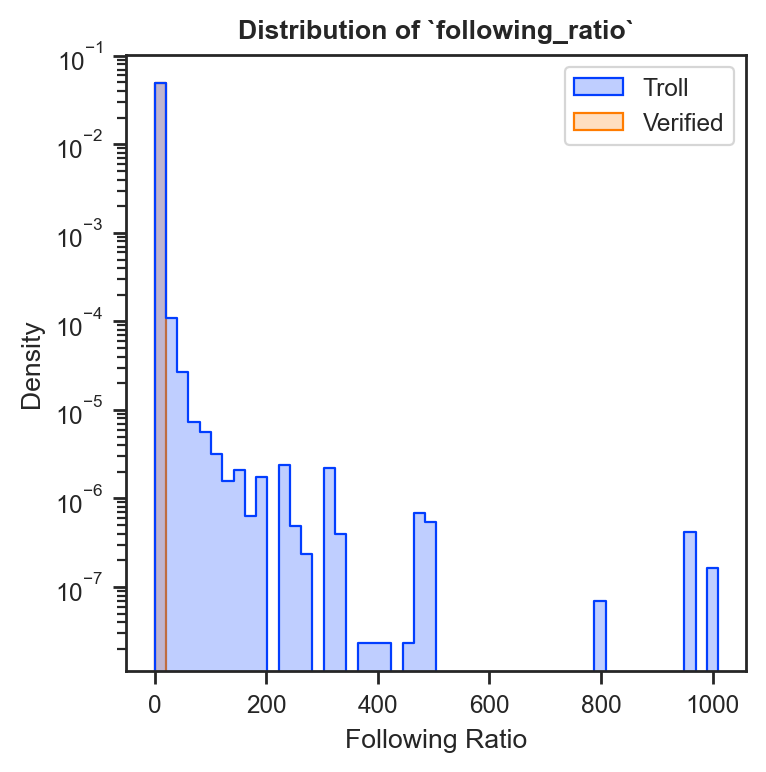

In [313]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of `following_ratio`", weight='bold')
ax.set_xlabel("Following Ratio")
ax.set_ylabel("Density")
ax.set_yscale("log")

sns.histplot(merged_df, 
                x='following_ratio', 
                hue='class',
                bins=50,
                #binrange=(0, 280),
                element='step',
                stat='density',
                common_norm=False,
                ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

## 6.3 - Average Tweets per Author

Note this is not representative of the entire population of Tweets, only of our dataset's sample of tweets/authors.

In [ ]:
avg_tweets_per_author: float = len(merged_df.index) / merged_df['author'].nunique()

print(f"Average tweets per author (in dataset):\t{avg_tweets_per_author:0.1f} tweets/author")

Average tweets per author (in dataset):	25.5 tweets/author


## 6.4 Tokenized "`content`"

### 6.4.1 NLTK regex-based Tokenizer

In [9]:
# break down all of the tweets into lists of tokens
tokenizer = RegexpTokenizer(r'\w+')     # matches between one and unlimited word characters [a-zA-Z0-9_]

In [49]:
# make a copy of author and content columns
author_tweets: pd.DataFrame = merged_df[['author', 'content']].copy()

# tokenize content column
author_tweets['content_tokens'] = author_tweets['content'].apply(tokenizer.tokenize)

# check output
author_tweets.sample(3)

,author,content,content_tokens
1683955,JENN_ABRAMS,"Turkish military launches airstrikes against Kurdish militants in Iraq, Turkey #breaking http://t.co/KSqIcriC4t","[Turkish, military, launches, airstrikes, against, Kurdish, militants, in, Iraq, Turkey, breaking, http, t, co, KSqIcriC4t]"
891524,BROSELIFOTR,Race Baiter Leading Fight Against Cleveland Indians Mascot INDICTED for FRAUD https://t.co/6M9GdRH8jK,"[Race, Baiter, Leading, Fight, Against, Cleveland, Indians, Mascot, INDICTED, for, FRAUD, https, t, co, 6M9GdRH8jK]"
2068643,PATRIOTOTUS,#SouthCarolina teen used mother’s gun to stop burglars. #BeingPatriotic https://t.co/dTwAx2fYF5 https://t.co/wzhBEtAnMg,"[SouthCarolina, teen, used, mother, s, gun, to, stop, burglars, BeingPatriotic, https, t, co, dTwAx2fYF5, https, t, co, wzhBEtAnMg]"


In [58]:
# condense `author_words` by author to combine all tokenized words (across tweets)
author_tweets_grouped = author_tweets.groupby(by=['author'], axis=0)    # type: pd.core.groupby.generic.DataFrameGroupBy

Note the following cell requires 21+ minutes to run (good candidate for PySpark!).

In [69]:
# make new dataframe with columns for author and all of their tokenized words
author_words = pd.DataFrame(data=author_tweets_grouped.groups.keys(), columns=['author'])

author_words['words'] = author_words['author'].apply(
    # lambda function applies to each unique author and receives a DataFrame from get_group.
    #   The DataFrame has columns [author, content, content_tokens], and each row a tweet
    #   by this author.
    lambda author: author_tweets_grouped.get_group(name=author)['content_tokens'].sum()
)

Note the following cell requires 2+ hours to run (and is also a good candidate for PySpark).

In [70]:
# also combine all the words into one giant Series
all_words: pd.Series = author_words['words'].sum()

In [ ]:
# determine the frequencies of these words
all_words_freq = all_words.value_counts()

In [ ]:
# save our processed words so we don't have to re-run again
# note this cell requires package `pyarrow` to be installed in environment
parq_path_author_words: str = f"{snapshot_paths['parq_snapshot']}/author_words.parquet.snappy"
parq_path_all_words: str = f"{snapshot_paths['parq_snapshot']}//all_words.parquet.snappy"

if (local_or_cloud == "local"):
    author_words.to_parquet(parq_path_author_words, engine='pyarrow')
    all_words.to_frame(name='words').to_parquet(parq_path_all_words, engine='pyarrow')
elif (local_or_cloud == "cloud"):
    pass

### 6.4.2 Word cloud visualization

In [ ]:
# add a few tokens to stop_words
stop_words.update(
        {"co", "https", "http", "RT"}
)

In [ ]:
# make a new view of all_words_freq
words_freq_no_stop_words = all_words_freq.loc[~all_words_freq.isin(stop_words)]

# visualize the frequencies of `all_words` with a word cloud
wordcloud_all_words: WordCloud = WordCloud(
    max_words=25,
    stopwords=stop_words,
).generate_from_frequencies(words_freq_no_stop_words.to_dict())

### 6.4.3 Token Length

In [ ]:
# convert all_words_freq into Dataframe with columns [token, count]
token_length = all_words_freq.to_frame(name='count').reset_index(names='token')

# add column for token length
token_length['token_length'] = token_length['token'].apply(len)

# groupby token_length, grab 'count' column from group, and sum
token_length_freq = token_length.groupby('token_length')['count'].sum()

# check results
token_length_freq.sort_values(ascending=False, inplace=True)
token_length_freq.head(20)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_title("Distribution of Token Length", weight='bold')
ax.set_xlabel("Token Length (characters)")
#ax.set_ylabel("Density")
#ax.set_yscale("log")

sns.barplot(x=token_length_freq.index,
            y=token_length_freq.values,
            color=twitter_colors['blue'],
            edgecolor=twitter_colors['dark blue'],
            ax=ax
            )

legend = ax.get_legend()
legend.set_title(None)

plt.show()

## 6.5 Bigrams